# Statistical Regressions

This notebook conducts a series of statistical regressions based on the filtered HMDA records in `data/processed/mortgage-records/filtered`. The key findings are logged in `output/logs/regression.txt` and standardized results of each logistic regression are logged in `output/logs/regression-odds-ratios.csv`. Please see the methodology document for additional context regarding these calculations.

## Setup

In [1]:
import itertools
import re

import numpy as np
import polars as pl
import polars.selectors as cs
import seaborn as sns
import seaborn.objects as so
import statsmodels.api as sm
from numpy.linalg import LinAlgError
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from utils.expressions import (
    EXPR_ETHN_SIMPLE,
    EXPR_IS_CREDIT_DENIAL,
    EXPR_RACE_ETHN,
    EXPR_RACE_SIMPLE,
)
from utils.helpers import make_logger, shift_columns_left
from utils.loaders import load_county_meta, load_hmda, load_lenders

In [2]:
log = make_logger("../output/logs/regression.txt", width=500)

In [3]:
with open("../output/logs/regression-odds-ratios.csv", "w") as f:
    f.write(
        "desc,variable,translation,comparison,odds_ratio,ci_low,ci_high,p,non_sig\n"
    )

translations = pl.read_csv("../data/manual/variable-translations.csv")


def log_regression(results, description, alpha=0.05):
    def assert_full_join(df):
        missing = set(df.filter(pl.col("translation").is_null())["variable"])
        if len(missing):
            raise Exception(f"Variable translations missing {missing}")
        return df

    df = (
        results.params.to_frame("odds_ratio")
        .apply(np.exp)
        .reset_index()
        .pipe(pl.DataFrame)
        .rename({"index": "variable"})
        .join(translations, on="variable", how="left")
        .pipe(assert_full_join)
        .with_columns(
            pl.lit(description).alias("desc"),
            pl.Series(results.conf_int()[0].values).exp().alias("ci_low"),
            pl.Series(results.conf_int()[1].values).exp().alias("ci_high"),
            pl.Series(results.pvalues).alias("p"),
        )
        .with_columns(
            (
                # (pl.count() - 1) to exclude Intercept from count
                pl.when(pl.col("p").gt(alpha / (pl.count() - 1)))
                .then(pl.lit("*"))
                .otherwise(pl.lit(""))
                .alias("non_sig")
            ),
        )
        .pipe(shift_columns_left, ["desc", "variable", "translation", "comparison"])
    )

    with open("../output/logs/regression-odds-ratios.csv", "a") as f:
        df.write_csv(f, include_header=False)

    return log(results.summary(), description)

In [4]:
def assess_results(results):
    predictions = results.predict(results.model.exog, transform=False)
    predictions_binary = predictions > 0.5
    outcomes = results.model.endog

    print(f"Pseudo R-squared: {results.prsquared:.4f}")
    print(f"AUC: {roc_auc_score(outcomes, predictions):.3f}")
    print(f"Recall: {recall_score(outcomes, predictions_binary):.3f}")
    print(f"Precision: {precision_score(outcomes, predictions_binary):.3f}")
    print(f"Accuracy score: {accuracy_score(outcomes, predictions_binary):.3f}")
    print(f"F-1 score: {f1_score(outcomes, predictions_binary):.3f}")

    names = ["True Approval", "False Approval", "False Denial", "True Denial"]
    cm = confusion_matrix(
        outcomes,
        predictions_binary,
        normalize="true",
    ).ravel()

    print("\n".join(f"{k:<15}: {v*100:4.1f}%" for k, v in zip(names, cm)))

## Load HMDA data

In [5]:
raw = load_hmda()
log(len(raw), "Total entries in filtered data")

Total entries in filtered data:


519624

## Load auxiliary datasets

In [6]:
lenders = load_lenders()
lenders.head()

lei,lender_name,lender_parent,lender_topholder,lender_agency,other_lender_code,lender_state,lender_assets,lender_year_max,lender_type
str,str,str,str,i64,i64,str,i64,i64,str
"""549300DKYWYDD1…","""SI Mortgage Co…",null,null,7,-1,null,-1,2018,"""bank_or_other"""
"""549300QZ613DTY…","""Ned Stevens In…",null,null,7,3,"""RI""",-1,2018,"""ind"""
"""549300983ZYTJM…","""Coastal Herita…","""SOUTH SHORE MU…","""SOUTH SHORE MU…",3,0,"""MA""",511852,2018,"""bank_or_other"""
"""984500DLB3V4F0…","""REDIGER INVEST…",null,null,9,5,"""CA""",-1,2018,"""bank_or_other"""
"""5493004XDYR0YX…","""Guaranty Bank …","""GUARANTY BANCO…","""GUARANTY BANCO…",2,0,"""CO""",3697445,2018,"""bank_or_other"""


In [7]:
# See utils/loaders.py for implementation of this inference
lenders["lender_type"].value_counts(sort=True)

lender_type,counts
str,u32
"""bank_or_other""",3288
"""cu""",1748
"""ind""",1130


In [8]:
(raw["lei"].is_in(lenders["lei"]).mean())

1.0

In [9]:
county_meta = load_county_meta()

county_meta.head()

county_code,county_name
str,str
"""34001""","""Atlantic Count…"
"""34003""","""Bergen County"""
"""34005""","""Burlington Cou…"
"""34007""","""Camden County"""
"""34009""","""Cape May Count…"


In [10]:
census_county = pl.read_csv("../data/processed/census/county-demographics.csv")

## Data prep

### Prepare categories

In [11]:
LOAN_AGGREGATES = (
    pl.count().alias("decisions"),
    (pl.col("ethn_simple").gt(2).mean().alias("prop_ethn_missing")),
    (pl.col("applicant_race_1").is_in([6, 7]).mean().alias("prop_race_missing")),
    (pl.col("applicant_sex").is_in([3, 4]).mean().alias("prop_sex_missing")),
    (
        pl.col("ethn_simple")
        .filter(pl.col("ethn_simple").le(2))
        .eq(1)
        .mean()
        .alias("prop_hl")
    ),
    (pl.col("action_taken").eq(3).mean().alias("prop_denied")),
    (
        pl.col("action_taken")
        .filter(pl.col("ethn_simple").eq(1))
        .eq(3)
        .mean()
        .alias("prop_denied_hl")
    ),
)

In [12]:
AGE_MAP = {
    "8888": "missing",
    "<25": "lt_25",
    "25-34": "25_34",
    "35-44": "35_44",
    "45-54": "45_54",
    "55-64": "55_64",
    "65-74": "65_plus",
    ">74": "65_plus",
}

In [13]:
(
    raw.select(pl.col("applicant_age").replace(AGE_MAP))["applicant_age"]
    .value_counts()
    .sort("applicant_age")
)

applicant_age,counts
str,u32
"""25_34""",176791
"""35_44""",164029
"""45_54""",90062
"""55_64""",50235
"""65_plus""",22999
"""lt_25""",15382
"""missing""",126


In [14]:
dti_categories = (
    raw["debt_to_income_ratio"]
    .value_counts()
    .with_columns(
        pl.col("debt_to_income_ratio")
        .str.extract(r"(\d+)")
        .alias("dti_int_lower")
        .cast(int)
    )
    .with_columns(
        pl.when(pl.col("dti_int_lower").lt(36))
        .then(pl.lit("healthy"))
        .when(pl.col("dti_int_lower").lt(43))
        .then(pl.lit("manageable"))
        .when(pl.col("dti_int_lower").lt(50))
        .then(pl.lit("unmanageable"))
        .when(pl.col("dti_int_lower").lt(60))
        .then(pl.lit("struggling"))
        .when(pl.col("dti_int_lower").ge(60))
        .then(pl.lit("most_struggling"))
        .alias("dti_cat")
    )
    # Creating another variable that matches The Markup's version
    .with_columns(
        pl.when(pl.col("dti_cat").eq("most_struggling"))
        .then(pl.lit("struggling"))
        .otherwise(pl.col("dti_cat"))
        .alias("dti_cat_mm")
    )
    .sort("dti_int_lower", "debt_to_income_ratio")
)

dti_categories

debt_to_income_ratio,counts,dti_int_lower,dti_cat,dti_cat_mm
str,u32,i64,str,str
null,4850,null,null,null
"""20%-<30%""",83070,20,"""healthy""","""healthy"""
"""<20%""",22087,20,"""healthy""","""healthy"""
"""30%-<36%""",83890,30,"""healthy""","""healthy"""
"""36""",16146,36,"""manageable""","""manageable"""
"""37""",17153,37,"""manageable""","""manageable"""
"""38""",17649,38,"""manageable""","""manageable"""
"""39""",18721,39,"""manageable""","""manageable"""
"""40""",19162,40,"""manageable""","""manageable"""


In [15]:
EXPR_HAS_COAPPLICANT = pl.any_horizontal(
    pl.col("co_applicant_sex").is_in([1, 2, 6]),
    ~pl.col("co_applicant_age").fill_null("9999").is_in(["8888", "9999"]),
    pl.col("co_applicant_ethnicity_1").cast(str).lt("3"),
    pl.col("co_applicant_race_1").cast(str).lt("6"),
    pl.col("co_applicant_credit_score_type").lt(9),
).alias("has_coapplicant")

In [16]:
(raw.select(EXPR_HAS_COAPPLICANT)["has_coapplicant"].value_counts(sort=True))

has_coapplicant,counts
bool,u32
false,289402
true,230222


In [17]:
EXPR_TRACT_INCOME_RATIO = (
    pl.col("tract_to_msa_income_percentage")
    .cut(
        [
            50,
            80,
            120,
        ],
        labels=["low", "moderate", "middle", "upper"],
        left_closed=True,
    )
    .alias("tract_income_ratio")
)

(
    raw.with_columns(EXPR_TRACT_INCOME_RATIO)
    .group_by("tract_income_ratio")
    .agg(
        pl.col("tract_to_msa_income_percentage").min().alias("min"),
        pl.col("tract_to_msa_income_percentage").max().alias("max"),
    )
    .sort("min")
)

tract_income_ratio,min,max
cat,f64,f64
"""low""",0.0,49.0
"""moderate""",50.0,79.0
"""middle""",80.0,119.0
"""upper""",120.0,370.0


In [18]:
EXPR_TRACT_PROP_WHITE = (
    pl.col("tract_minority_population_percent")
    .mul(-1)
    .add(100)
    .cut([25, 50, 75], labels=["q1", "q2", "q3", "q4"], left_closed=True)
    .alias("tract_whiteness")
)

(
    raw.with_columns(EXPR_TRACT_PROP_WHITE)
    .group_by("tract_whiteness")
    .agg(
        pl.col("tract_minority_population_percent").min().alias("min"),
        pl.col("tract_minority_population_percent").max().alias("max"),
    )
    .sort("min")
)

tract_whiteness,min,max
cat,f64,f64
"""q4""",0.0,24.99
"""q3""",25.01,50.0
"""q2""",50.01,74.94
"""q1""",75.02,100.0


### Build `lender_application_counts`

In [19]:
(raw.with_columns(EXPR_ETHN_SIMPLE)["ethn_simple"].value_counts(sort=True))

ethn_simple,counts
i64,u32
2,373702
1,75214
3,70344
null,203
4,161


In [20]:
lender_application_counts = (
    raw.with_columns(EXPR_ETHN_SIMPLE)
    .group_by("lei")
    .agg(
        pl.col("ethn_simple").eq(1).mean().alias("lender_ethn_hl"),
        # Note: Here we consider the (very few) free-text entries
        # as missing
        (
            pl.col("ethn_simple")
            .fill_null(999)
            .gt(2)
            .mean()
            .alias("lender_ethn_missing")
        ),
        pl.count().alias("num_decisions"),
        pl.col("loan_type").eq(1).sum().alias("num_decisions_conv"),
        pl.col("loan_type").eq(2).sum().alias("num_decisions_fha"),
    )
    .sort("lei")
)

lender_application_counts.head()

lei,lender_ethn_hl,lender_ethn_missing,num_decisions,num_decisions_conv,num_decisions_fha
str,f64,f64,u32,u32,u32
"""03D0JEWFDFUS0S…",0.083596,0.208089,6651,6421,230
"""0K2D5AK28E3O5C…",0.0,0.171429,35,35,0
"""0S8H5NJFLHEVJX…",0.0,0.0,1,1,0
"""1IE8VN30JCEQV1…",0.046875,0.446034,769,769,0
"""1TMVIO1SD0RLIP…",0.0,0.0,2,2,0


### Build `for_modeling` DataFrame

In [21]:
for_modeling = (
    raw.with_columns(
        # To preserve this variable when converting activity_years to dummies
        pl.col("activity_year").alias("year")
    )
    .join(
        (dti_categories.select("debt_to_income_ratio", "dti_cat", "dti_cat_mm")),
        how="left",
        on="debt_to_income_ratio",
    )
    .join(
        lender_application_counts,
        how="left",
        on="lei",
    )
    .join(lenders.select("lei", "lender_type"), how="left", on="lei")
    .join(
        census_county.select(
            pl.col("county_code").cast(str),
            pl.all().name.suffix("_county"),
        ),
        how="left",
        on="county_code",
    )
    .with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .with_columns(EXPR_RACE_ETHN)
    .with_columns(EXPR_TRACT_INCOME_RATIO)
    .with_columns(EXPR_TRACT_PROP_WHITE)
    .with_columns(
        pl.col("action_taken").eq(3).alias("is_denied").cast(int),
        pl.col("ethn_simple").eq(1).alias("ethn_is_hl").cast(int),
        pl.col("ethn_simple").fill_null(999).gt(2).alias("ethn_missing").cast(int),
        pl.col("applicant_ethnicity_observed").eq(1).alias("ethn_observed").cast(int),
        pl.col("applicant_race_1")
        .fill_null(999)
        .is_in([6, 7, 999])
        .alias("race_missing")
        .cast(int),
        pl.col("applicant_sex").eq(1).alias("sex_is_male").cast(int),
        pl.col("applicant_sex").eq(2).alias("sex_is_female").cast(int),
        pl.col("applicant_sex")
        .fill_null(999)
        .is_in([3, 4, 999])
        .alias("sex_missing")
        .cast(int),
        pl.col("applicant_sex").eq(6).alias("sex_is_both").cast(int),
        pl.col("applicant_sex")
        .fill_null(999)
        .is_in([3, 4, 6, 999])
        .alias("sex_missing_or_both")
        .cast(int),
        pl.col("applicant_age").replace(AGE_MAP).alias("age"),
        EXPR_HAS_COAPPLICANT.cast(int).alias("has_coapplicant"),
        pl.col("loan_amount").log10().alias("loan_amount_log10"),
        pl.col("income").log10().alias("income_log10"),
        pl.col("pop_total_county").log10().alias("pop_total_county_log10"),
        pl.col("num_decisions").truediv(1000).alias("num_decisions_1000"),
        pl.col("loan_term").fill_null(360).lt(360).alias("term_lt_30y").cast(int),
        pl.col("loan_term").fill_null(360).gt(360).alias("term_gt_30y").cast(int),
        pl.col("applicant_credit_score_type")
        .replace(
            {
                1: "equifax",
                2: "experian",
                3: "transunion",
                4: "transunion",
                5: "other",
                6: "other",
                7: "multiple",
                8: "other",
                9: "missing",
                # 11 is a very uncommon value, does not seem to map to any
                # entry in the HMDA data dictionary
                11: "missing",
                1111: "missing",
            }
        )
        .alias("credit_model_simple"),
        pl.col("aus_1")
        .replace(
            {
                1: "desktop_yes",
                2: "desktop_no",
                3: "desktop_no",
                4: "desktop_no",
                5: "desktop_no",
                6: "missing",
                7: "desktop_no",
                1111: "missing",
            }
        )
        .alias("aus_coarse"),
        pl.col("aus_1")
        .replace(
            {
                1: "desktop",
                2: "other",
                3: "total",
                4: "other",
                5: "other",
                6: "missing",
                7: "other",
                1111: "missing",
            }
        )
        .alias("aus_detailed"),
    )
    .to_dummies("dti_cat")
    .to_dummies("dti_cat_mm")
    .to_dummies("age")
    .to_dummies("activity_year")
    .to_dummies("aus_coarse")
    .to_dummies("aus_detailed")
    .to_dummies("credit_model_simple")
    .to_dummies("tract_whiteness")
    .to_dummies("tract_income_ratio")
    .to_dummies("lender_type")
    .to_dummies("race_ethn")
)

assert len(for_modeling) == len(raw)

### Set up variable groups

In [22]:
formula_vars = {
    # Applicant race and ethnicity
    "race_ethn": [
        "race_ethn_hl",
        "race_ethn_black",
        "race_ethn_asian",
        "race_ethn_pacific_islander",
        "race_ethn_native",
    ],
    "race_ethn_missing": [
        "race_ethn_missing",
    ],
    "race_ethn_missing_detailed": [
        "race_missing*ethn_missing",
    ],
    "ethn_observed": ["ethn_observed"],
    # Applicant sex
    "sex": [
        "sex_is_female",
        "sex_missing_or_both",
    ],
    # Applicant age
    "age": [
        "age_lt_25",
        "age_25_34",
        "age_45_54",
        "age_55_64",
        "age_65_plus",
        "age_missing",
    ],
    "age_without_missing": [
        "age_lt_25",
        "age_25_34",
        "age_45_54",
        "age_55_64",
        "age_65_plus",
    ],
    # Co-applicant
    "coapp": [
        "has_coapplicant",
    ],
    # Income
    "income": [
        "income_log10",
    ],
    # Loan amount
    "loan_amount": ["loan_amount_log10"],
    # Debt-to-income ratio
    "dti": [
        "dti_cat_mm_manageable",
        "dti_cat_mm_unmanageable",
        "dti_cat_mm_struggling",
    ],
    # Debt-to-income ratio
    "dti_2": [
        "dti_cat_manageable",
        "dti_cat_unmanageable",
        "dti_cat_struggling",
        "dti_cat_most_struggling",
    ],
    # Loan-to-value ratio
    "ltv": ["combined_loan_to_value_ratio"],
    # Mortgage term
    "term": ["term_lt_30y", "term_gt_30y"],
    # Credit model
    "credit_model": [
        "credit_model_simple_equifax",
        "credit_model_simple_experian",
        "credit_model_simple_multiple",
        "credit_model_simple_other",
        "credit_model_simple_missing",
    ],
    # Lender volume
    "volume": ["num_decisions_1000"],
    # AUS
    "aus_coarse": [
        "aus_coarse_desktop_no",
        "aus_coarse_missing",
    ],
    "aus_detailed": [
        "aus_detailed_total",
        "aus_detailed_other",
        "aus_detailed_missing",
    ],
    # Lender type
    "lender_type": [
        "lender_type_cu",
        "lender_type_ind",
    ],
    # Tract whiteness
    "tract_whiteness": [
        "tract_whiteness_q1",
        "tract_whiteness_q2",
        "tract_whiteness_q3",
    ],
    # Tract-to-MSA income ratio
    "tract_income": [
        "tract_income_ratio_low",
        "tract_income_ratio_moderate",
        "tract_income_ratio_upper",
    ],
    # County size
    "county_size": ["pop_total_county_log10"],
}

In [23]:
def get_indep_vars(variable_sets):
    return list(itertools.chain(*(formula_vars[vs] for vs in variable_sets)))

In [24]:
def build_formula(variable_sets):
    left = "is_denied"
    right = " + \n  ".join(" + ".join(formula_vars[vs]) for vs in variable_sets)
    return f"{left} ~ \n  {right}"

### Set up core filter

In [25]:
core_filter = (
    pl.col("income").gt(0)
    & pl.col("combined_loan_to_value_ratio").le(100)
    & ~pl.col("combined_loan_to_value_ratio").is_null()
    & ~pl.col("debt_to_income_ratio").is_null()
    & ~pl.col("census_tract").is_null()
    & ~pl.col("pop_total_county").is_null()
)

### Checking demographic differences in filtered data

In [26]:
def examine_filter(df, filter_expr):
    return (
        df.with_columns(EXPR_RACE_ETHN)
        .group_by("loan_type", "race_ethn")
        .agg(
            ((~filter_expr).mean().round(3).alias("filtered_out")),
            (pl.col("is_denied").mean().round(3).alias("is_denied_all")),
            (
                pl.col("is_denied")
                .filter(~filter_expr)
                .mean()
                .round(3)
                .alias("is_denied_out")
            ),
            (
                pl.col("is_denied")
                .filter(filter_expr)
                .mean()
                .round(3)
                .alias("is_denied_in")
            ),
        )
        .sort("loan_type", "race_ethn", descending=(False, True))
    )

In [27]:
examine_filter(for_modeling, core_filter)

loan_type,race_ethn,filtered_out,is_denied_all,is_denied_out,is_denied_in
i64,str,f64,f64,f64,f64
1,"""white""",0.035,0.058,0.194,0.054
1,"""pacific_island…",0.049,0.137,0.529,0.118
1,"""native""",0.079,0.111,0.327,0.092
1,"""missing""",0.029,0.102,0.379,0.094
1,"""hl""",0.042,0.113,0.343,0.103
1,"""black""",0.062,0.154,0.398,0.138
1,"""asian""",0.03,0.089,0.239,0.084
2,"""white""",0.126,0.104,0.146,0.098
2,"""pacific_island…",0.109,0.173,0.294,0.158


## Model 1: Markup Replication

In [28]:
m1_filter = core_filter & ~pl.col("action_taken").eq(2)

In [29]:
examine_filter(for_modeling, m1_filter)

loan_type,race_ethn,filtered_out,is_denied_all,is_denied_out,is_denied_in
i64,str,f64,f64,f64,f64
1,"""white""",0.061,0.058,0.111,0.055
1,"""pacific_island…",0.08,0.137,0.321,0.122
1,"""native""",0.108,0.111,0.24,0.095
1,"""missing""",0.059,0.102,0.187,0.097
1,"""hl""",0.067,0.113,0.212,0.106
1,"""black""",0.094,0.154,0.262,0.143
1,"""asian""",0.06,0.089,0.117,0.087
2,"""white""",0.152,0.104,0.121,0.101
2,"""pacific_island…",0.135,0.173,0.238,0.163


In [30]:
m1_variables = [
    "race_ethn",
    "race_ethn_missing",
    "sex",
    "age",
    "coapp",
    "income",
    "loan_amount",
    "dti",
    "ltv",
    "term",
    "credit_model",
    "volume",
    "aus_coarse",
    "lender_type",
    "tract_whiteness",
    "tract_income",
    "county_size",
]
m1_formula = build_formula(m1_variables)
print(m1_formula)

is_denied ~ 
  race_ethn_hl + race_ethn_black + race_ethn_asian + race_ethn_pacific_islander + race_ethn_native + 
  race_ethn_missing + 
  sex_is_female + sex_missing_or_both + 
  age_lt_25 + age_25_34 + age_45_54 + age_55_64 + age_65_plus + age_missing + 
  has_coapplicant + 
  income_log10 + 
  loan_amount_log10 + 
  dti_cat_mm_manageable + dti_cat_mm_unmanageable + dti_cat_mm_struggling + 
  combined_loan_to_value_ratio + 
  term_lt_30y + term_gt_30y + 
  credit_model_simple_equifax + credit_model_simple_experian + credit_model_simple_multiple + credit_model_simple_other + credit_model_simple_missing + 
  num_decisions_1000 + 
  aus_coarse_desktop_no + aus_coarse_missing + 
  lender_type_cu + lender_type_ind + 
  tract_whiteness_q1 + tract_whiteness_q2 + tract_whiteness_q3 + 
  tract_income_ratio_low + tract_income_ratio_moderate + tract_income_ratio_upper + 
  pop_total_county_log10


### Conventional

In [31]:
# Conventional
model = sm.Logit.from_formula(
    data=for_modeling.filter(m1_filter).filter(pl.col("loan_type").eq(1)),
    formula=m1_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional")

Model 1, conventional:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               367664
Model:                          Logit   Df Residuals:                   367623
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2113
Time:                        21:44:21   Log-Likelihood:                -77433.
converged:                       True   LL-Null:                       -98174.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6335      0.245     -6.676      0.000      -2.113      -1.154
race_ethn_hl                     0.3411      0.023     14.566      0.000       0.295       0.387
race_ethn_black                  0.6116      0.029     21.245      0.000       0.555       0.668
race_ethn_asian                  0.3922      0.022     17.919      0.000       0.349       0.435
race_ethn_pacific_islander       0.6715      0.197      3.406      0.001       0.285       1.058
race_ethn_native                 0.3574      0.159      2.246      0.025       0.046       0.669
race_ethn_missing                0.4285      0.026     16.786      0.000       0.379       0.479
sex_is_female                   -0.0970      0.016     -6.087      0.000      -0.128      -0.066
sex_missing_or_both              0.1928      0.033      5.810      0.000       0.128       0.258
age_lt_25                        0.0384      0.045      0.858      0.391      -0.049       0.126
age_25_34                       -0.1294      0.019     -6.982      0.000      -0.166      -0.093
age_45_54                        0.2215      0.021     10.806      0.000       0.181       0.262
age_55_64                        0.2258      0.025      8.880      0.000       0.176       0.276
age_65_plus                      0.0623      0.036      1.737      0.082      -0.008       0.133
age_missing                      2.6654      0.339      7.868      0.000       2.001       3.329
has_coapplicant                 -0.3055      0.016    -18.811      0.000      -0.337      -0.274
income_log10                     0.1019      0.041      2.516      0.012       0.023       0.181
loan_amount_log10               -0.6096      0.044    -13.934      0.000      -0.695      -0.524
dti_cat_mm_manageable           -0.0013      0.019     -0.068      0.946      -0.039       0.037
dti_cat_mm_unmanageable          0.3013      0.020     15.286      0.000       0.263       0.340
dti_cat_mm_struggling            3.8156      0.027    139.669      0.000       3.762       3.869
combined_loan_to_value_ratio     0.0143      0.001     24.048      0.000       0.013       0.015
term_lt_30y                      0.0359      0.032      1.128      0.259      -0.026       0.098
term_gt_30y                      1.0238      0.126      8.121      0.000       0.777       1.271
credit_model_simple_equifax      0.0206      0.018      1.129      0.259      -0.015       0.056
credit_model_simple_experian     0.0474      0.019      2.453      0.014       0.010       0.085
credit_model_simple_multiple    -0.3031      0.041     -7.463      0.000      -0.383      -0.224
credit_model_simple_other        0.4372      0.061      7.133      0.000       0.317       0.557
credit_model_simple_missing      0.4858      0.028     17.109      0.000       0.430       0.541
num_decisions_1000               0.0206      0.001     20.249      0.000       0.019       0.023
aus_coarse_desktop_no           -0.1246 

In [32]:
assess_results(results)

Pseudo R-squared: 0.2113
AUC: 0.773
Recall: 0.295
Precision: 0.725
Accuracy score: 0.939
F-1 score: 0.420
True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 70.5%
True Denial    : 29.5%


True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 70.5%
True Denial    : 29.5%


#### Standard error clustering

To test the sensitivity of the confidence intervals to non-independence of applications at the county or lender level, we examine the results when clustering the standard errors by county (`county_code`) and by lender (`lei`):

In [33]:
# Clustering standard errors by county_code
(
    for_modeling.filter(m1_filter)
    .filter(pl.col("loan_type").eq(1))
    .pipe(
        lambda df: (
            sm.Logit.from_formula(data=df, formula=m1_formula).fit(
                disp=0,
                cov_type="cluster",
                cov_kwds={"groups": df["county_code"].to_pandas()},
            )
        )
    )
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               367664
Model:                          Logit   Df Residuals:                   367623
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2113
Time:                        21:44:26   Log-Likelihood:                -77433.
converged:                       True   LL-Null:                       -98174.
Covariance Type:              cluster   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6335      0.707     -2.311      0.021      -3.019      -0.248
race_ethn_hl                     0.3411      0.036      9.424      0.000       0.270       0.412
race_ethn_black                  0.6116      0.041     15.058      0.000       0.532       0.691
race_ethn_asian                  0.3922      0.024     16.280      0.000       0.345       0.439
race_ethn_pacific_islander       0.6715      0.202      3.328      0.001       0.276       1.067
race_ethn_native                 0.3574      0.098      3.646      0.000       0.165       0.550
race_ethn_missing                0.4285      0.030     14.196      0.000       0.369       0.488
sex_is_female                   -0.0970      0.020     -4.884      0.000      -0.136      -0.058
sex_missing_or_both              0.1928      0.030      6.398      0.000       0.134       0.252
age_lt_25                        0.0384      0.059      0.647      0.518      -0.078       0.155
age_25_34                       -0.1294      0.031     -4.220      0.000      -0.190      -0.069
age_45_54                        0.2215      0.024      9.170      0.000       0.174       0.269
age_55_64                        0.2258      0.032      7.023      0.000       0.163       0.289
age_65_plus                      0.0623      0.069      0.903      0.366      -0.073       0.197
age_missing                      2.6654      0.276      9.663      0.000       2.125       3.206
has_coapplicant                 -0.3055      0.026    -11.884      0.000      -0.356      -0.255
income_log10                     0.1019      0.074      1.381      0.167      -0.043       0.247
loan_amount_log10               -0.6096      0.093     -6.571      0.000      -0.791      -0.428
dti_cat_mm_manageable           -0.0013      0.027     -0.049      0.961      -0.053       0.051
dti_cat_mm_unmanageable          0.3013      0.034      8.777      0.000       0.234       0.369
dti_cat_mm_struggling            3.8156      0.045     84.387      0.000       3.727       3.904
combined_loan_to_value_ratio     0.0143      0.001     20.517      0.000       0.013       0.016
term_lt_30y                      0.0359      0.030      1.190      0.234      -0.023       0.095
term_gt_30y                      1.0238      0.165      6.198      0.000       0.700       1.348
credit_model_simple_equifax      0.0206      0.026      0.789      0.430      -0.031       0.072
credit_model_simple_experian     0.0474      0.023      2.022      0.043       0.001       0.093
credit_model_simple_multiple    -0.3031      0.070     -4.319      0.000      -0.441      -0.166
credit_model_simple_other        0.4372      0.092      4.750      0.000       0.257       0.618
credit_model_simple_missing      0.4858      0.025     19.736      0.000       0.438       0.534
num_decisions_1000               0.0206      0.002     12.340      0.000       0.017       0.024
aus_coarse_desktop_no           -0.1246 

In [34]:
# Clustering standard errors by lei
(
    for_modeling.filter(m1_filter)
    .filter(pl.col("loan_type").eq(1))
    .pipe(
        lambda df: (
            sm.Logit.from_formula(data=df, formula=m1_formula).fit(
                disp=0, cov_type="cluster", cov_kwds={"groups": df["lei"].to_pandas()}
            )
        )
    )
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               367664
Model:                          Logit   Df Residuals:                   367623
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2113
Time:                        21:44:30   Log-Likelihood:                -77433.
converged:                       True   LL-Null:                       -98174.
Covariance Type:              cluster   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6335      0.659     -2.478      0.013      -2.925      -0.342
race_ethn_hl                     0.3411      0.037      9.243      0.000       0.269       0.413
race_ethn_black                  0.6116      0.050     12.157      0.000       0.513       0.710
race_ethn_asian                  0.3922      0.043      9.066      0.000       0.307       0.477
race_ethn_pacific_islander       0.6715      0.187      3.585      0.000       0.304       1.039
race_ethn_native                 0.3574      0.144      2.488      0.013       0.076       0.639
race_ethn_missing                0.4285      0.051      8.486      0.000       0.330       0.528
sex_is_female                   -0.0970      0.022     -4.412      0.000      -0.140      -0.054
sex_missing_or_both              0.1928      0.097      1.995      0.046       0.003       0.382
age_lt_25                        0.0384      0.052      0.734      0.463      -0.064       0.141
age_25_34                       -0.1294      0.025     -5.262      0.000      -0.178      -0.081
age_45_54                        0.2215      0.022      9.882      0.000       0.178       0.265
age_55_64                        0.2258      0.032      6.994      0.000       0.163       0.289
age_65_plus                      0.0623      0.043      1.450      0.147      -0.022       0.146
age_missing                      2.6654      0.669      3.984      0.000       1.354       3.977
has_coapplicant                 -0.3055      0.041     -7.525      0.000      -0.385      -0.226
income_log10                     0.1019      0.108      0.947      0.344      -0.109       0.313
loan_amount_log10               -0.6096      0.125     -4.889      0.000      -0.854      -0.365
dti_cat_mm_manageable           -0.0013      0.036     -0.036      0.971      -0.072       0.070
dti_cat_mm_unmanageable          0.3013      0.059      5.103      0.000       0.186       0.417
dti_cat_mm_struggling            3.8156      0.190     20.069      0.000       3.443       4.188
combined_loan_to_value_ratio     0.0143      0.001     12.830      0.000       0.012       0.016
term_lt_30y                      0.0359      0.059      0.604      0.546      -0.081       0.152
term_gt_30y                      1.0238      0.261      3.915      0.000       0.511       1.536
credit_model_simple_equifax      0.0206      0.041      0.508      0.611      -0.059       0.100
credit_model_simple_experian     0.0474      0.043      1.092      0.275      -0.038       0.133
credit_model_simple_multiple    -0.3031      0.217     -1.400      0.162      -0.727       0.121
credit_model_simple_other        0.4372      0.174      2.508      0.012       0.096       0.779
credit_model_simple_missing      0.4858      0.159      3.060      0.002       0.175       0.797
num_decisions_1000               0.0206      0.012      1.724      0.085      -0.003       0.044
aus_coarse_desktop_no           -0.1246 

### FHA

In [35]:
# FHA
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("loan_type").eq(2))
        .filter(pl.col("term_gt_30y").eq(0))
    ),
    formula=m1_formula.replace("term_gt_30y + ", ""),
)
results = model.fit(disp=0)
log_regression(results, "Model 1, FHA")

Model 1, FHA:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               105197
Model:                          Logit   Df Residuals:                   105157
Method:                           MLE   Df Model:                           39
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                 0.08001
Time:                        21:44:31   Log-Likelihood:                -37599.
converged:                       True   LL-Null:                       -40869.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.7864      0.345     -5.179      0.000      -2.462      -1.110
race_ethn_hl                     0.1381      0.027      5.022      0.000       0.084       0.192
race_ethn_black                  0.4082      0.029     13.856      0.000       0.350       0.466
race_ethn_asian                  0.4989      0.052      9.638      0.000       0.397       0.600
race_ethn_pacific_islander       0.4035      0.244      1.656      0.098      -0.074       0.881
race_ethn_native                 0.4506      0.195      2.314      0.021       0.069       0.832
race_ethn_missing                0.3197      0.035      9.032      0.000       0.250       0.389
sex_is_female                   -0.0668      0.020     -3.300      0.001      -0.107      -0.027
sex_missing_or_both              0.1414      0.048      2.967      0.003       0.048       0.235
age_lt_25                       -0.0432      0.052     -0.838      0.402      -0.144       0.058
age_25_34                       -0.1370      0.024     -5.610      0.000      -0.185      -0.089
age_45_54                        0.1322      0.026      4.992      0.000       0.080       0.184
age_55_64                        0.2177      0.035      6.244      0.000       0.149       0.286
age_65_plus                      0.3624      0.060      6.010      0.000       0.244       0.481
age_missing                      0.4360      0.569      0.767      0.443      -0.679       1.551
has_coapplicant                 -0.0446      0.021     -2.107      0.035      -0.086      -0.003
income_log10                    -1.4838      0.059    -24.970      0.000      -1.600      -1.367
loan_amount_log10                0.7514      0.068     11.122      0.000       0.619       0.884
dti_cat_mm_manageable           -0.2101      0.039     -5.438      0.000      -0.286      -0.134
dti_cat_mm_unmanageable         -0.2884      0.036     -8.008      0.000      -0.359      -0.218
dti_cat_mm_struggling            0.4631      0.034     13.734      0.000       0.397       0.529
combined_loan_to_value_ratio    -0.0198      0.001    -13.803      0.000      -0.023      -0.017
term_lt_30y                      0.9657      0.154      6.279      0.000       0.664       1.267
credit_model_simple_equifax      0.1175      0.025      4.697      0.000       0.068       0.167
credit_model_simple_experian     0.0567      0.026      2.193      0.028       0.006       0.107
credit_model_simple_multiple    -0.2429      0.039     -6.181      0.000      -0.320      -0.166
credit_model_simple_other        0.1685      0.104      1.613      0.107      -0.036       0.373
credit_model_simple_missing      0.5926      0.042     14.249      0.000       0.511       0.674
num_decisions_1000               0.0152      0.002      8.913      0.000       0.012       0.019
aus_coarse_desktop_no            0.1887      0.021      8.808      0.000       0.147       0.231
aus_coarse_missing               1.8461 

In [36]:
assess_results(results)

Pseudo R-squared: 0.0800
AUC: 0.691
Recall: 0.055
Precision: 0.575
Accuracy score: 0.871
F-1 score: 0.101
True Approval  : 99.4%
False Approval :  0.6%
False Denial   : 94.5%
True Denial    :  5.5%


## Model 2: Slight adjustments

In [37]:
m2_variables = [
    "race_ethn",
    "race_ethn_missing_detailed",
    "ethn_observed",
    "sex",
    "age_without_missing",
    "coapp",
    "income",
    "loan_amount",
    "dti_2",
    "ltv",
    "credit_model",
    "volume",
    "aus_detailed",
    "lender_type",
    "tract_whiteness",
    "tract_income",
    "county_size",
]
m2_formula = build_formula(m2_variables)
print(m2_formula)

is_denied ~ 
  race_ethn_hl + race_ethn_black + race_ethn_asian + race_ethn_pacific_islander + race_ethn_native + 
  race_missing*ethn_missing + 
  ethn_observed + 
  sex_is_female + sex_missing_or_both + 
  age_lt_25 + age_25_34 + age_45_54 + age_55_64 + age_65_plus + 
  has_coapplicant + 
  income_log10 + 
  loan_amount_log10 + 
  dti_cat_manageable + dti_cat_unmanageable + dti_cat_struggling + dti_cat_most_struggling + 
  combined_loan_to_value_ratio + 
  credit_model_simple_equifax + credit_model_simple_experian + credit_model_simple_multiple + credit_model_simple_other + credit_model_simple_missing + 
  num_decisions_1000 + 
  aus_detailed_total + aus_detailed_other + aus_detailed_missing + 
  lender_type_cu + lender_type_ind + 
  tract_whiteness_q1 + tract_whiteness_q2 + tract_whiteness_q3 + 
  tract_income_ratio_low + tract_income_ratio_moderate + tract_income_ratio_upper + 
  pop_total_county_log10


In [38]:
m2_filter = core_filter & pl.col("loan_term").eq(30 * 12) & pl.col("age_missing").eq(0)

In [39]:
examine_filter(for_modeling, m2_filter)

loan_type,race_ethn,filtered_out,is_denied_all,is_denied_out,is_denied_in
i64,str,f64,f64,f64,f64
1,"""white""",0.084,0.058,0.113,0.054
1,"""pacific_island…",0.103,0.137,0.278,0.122
1,"""native""",0.154,0.111,0.234,0.088
1,"""missing""",0.088,0.102,0.196,0.093
1,"""hl""",0.072,0.113,0.254,0.102
1,"""black""",0.087,0.154,0.335,0.136
1,"""asian""",0.151,0.089,0.102,0.086
2,"""white""",0.129,0.104,0.148,0.098
2,"""pacific_island…",0.115,0.173,0.278,0.159


### Conventional

In [40]:
# Conventional, 2
model = sm.Logit.from_formula(
    data=(for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(1))),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional")

Model 2, conventional:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               355611
Model:                          Logit   Df Residuals:                   355568
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2145
Time:                        21:44:35   Log-Likelihood:                -72916.
converged:                       True   LL-Null:                       -92831.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.3906      0.256     -5.442      0.000      -1.892      -0.890
race_ethn_hl                     0.2860      0.024     11.707      0.000       0.238       0.334
race_ethn_black                  0.5791      0.029     19.765      0.000       0.522       0.637
race_ethn_asian                  0.3990      0.023     17.538      0.000       0.354       0.444
race_ethn_pacific_islander       0.7501      0.198      3.796      0.000       0.363       1.137
race_ethn_native                 0.2847      0.168      1.697      0.090      -0.044       0.613
race_missing                     0.2995      0.037      8.167      0.000       0.228       0.371
ethn_missing                     0.2792      0.045      6.172      0.000       0.191       0.368
race_missing:ethn_missing       -0.1501      0.062     -2.411      0.016      -0.272      -0.028
ethn_observed                   -0.0164      0.070     -0.236      0.814      -0.153       0.120
sex_is_female                   -0.0886      0.016     -5.393      0.000      -0.121      -0.056
sex_missing_or_both              0.1790      0.036      5.039      0.000       0.109       0.249
age_lt_25                        0.0256      0.046      0.552      0.581      -0.065       0.116
age_25_34                       -0.1240      0.019     -6.497      0.000      -0.161      -0.087
age_45_54                        0.2198      0.021     10.367      0.000       0.178       0.261
age_55_64                        0.2172      0.027      8.186      0.000       0.165       0.269
age_65_plus                      0.0371      0.038      0.983      0.326      -0.037       0.111
has_coapplicant                 -0.3201      0.017    -19.030      0.000      -0.353      -0.287
income_log10                     0.3114      0.043      7.210      0.000       0.227       0.396
loan_amount_log10               -0.7581      0.046    -16.417      0.000      -0.849      -0.668
dti_cat_manageable               0.0345      0.020      1.717      0.086      -0.005       0.074
dti_cat_unmanageable             0.3480      0.020     17.052      0.000       0.308       0.388
dti_cat_struggling               3.3365      0.031    107.794      0.000       3.276       3.397
dti_cat_most_struggling          4.6956      0.045    104.444      0.000       4.607       4.784
combined_loan_to_value_ratio     0.0147      0.001     23.129      0.000       0.013       0.016
credit_model_simple_equifax      0.0204      0.019      1.080      0.280      -0.017       0.057
credit_model_simple_experian     0.0522      0.020      2.611      0.009       0.013       0.091
credit_model_simple_multiple    -0.2857      0.042     -6.866      0.000      -0.367      -0.204
credit_model_simple_other        0.4572      0.063      7.252      0.000       0.334       0.581
credit_model_simple_missing      0.4659      0.029     15.908      0.000       0.409       0.523
num_decisions_1000               0.0220 

In [41]:
assess_results(results)

Pseudo R-squared: 0.2145
AUC: 0.773
Recall: 0.278
Precision: 0.757
Accuracy score: 0.941
F-1 score: 0.406
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 72.2%
True Denial    : 27.8%


### FHA

In [42]:
# FHA, 2
model = sm.Logit.from_formula(
    data=(for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(2))),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, FHA")

Model 2, FHA:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               108504
Model:                          Logit   Df Residuals:                   108461
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.1735
Time:                        21:44:37   Log-Likelihood:                -34000.
converged:                       True   LL-Null:                       -41137.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0565      0.365     -0.155      0.877      -0.772       0.659
race_ethn_hl                     0.1240      0.030      4.196      0.000       0.066       0.182
race_ethn_black                  0.3927      0.031     12.576      0.000       0.332       0.454
race_ethn_asian                  0.4762      0.056      8.431      0.000       0.365       0.587
race_ethn_pacific_islander       0.3755      0.270      1.389      0.165      -0.154       0.905
race_ethn_native                 0.4854      0.206      2.354      0.019       0.081       0.889
race_missing                     0.3945      0.045      8.800      0.000       0.307       0.482
ethn_missing                     0.1863      0.069      2.706      0.007       0.051       0.321
race_missing:ethn_missing       -0.2416      0.088     -2.756      0.006      -0.413      -0.070
ethn_observed                   -0.0243      0.074     -0.330      0.741      -0.169       0.120
sex_is_female                   -0.0545      0.022     -2.498      0.013      -0.097      -0.012
sex_missing_or_both              0.1379      0.052      2.638      0.008       0.035       0.240
age_lt_25                       -0.0469      0.056     -0.831      0.406      -0.158       0.064
age_25_34                       -0.1337      0.026     -5.078      0.000      -0.185      -0.082
age_45_54                        0.1368      0.028      4.816      0.000       0.081       0.192
age_55_64                        0.2074      0.037      5.534      0.000       0.134       0.281
age_65_plus                      0.3779      0.064      5.866      0.000       0.252       0.504
has_coapplicant                 -0.2029      0.023     -8.767      0.000      -0.248      -0.158
income_log10                    -0.3046      0.070     -4.352      0.000      -0.442      -0.167
loan_amount_log10               -0.0266      0.072     -0.370      0.711      -0.168       0.114
dti_cat_manageable              -0.1012      0.039     -2.610      0.009      -0.177      -0.025
dti_cat_unmanageable            -0.1135      0.036     -3.114      0.002      -0.185      -0.042
dti_cat_struggling               0.1635      0.035      4.614      0.000       0.094       0.233
dti_cat_most_struggling          3.8876      0.060     65.177      0.000       3.771       4.004
combined_loan_to_value_ratio    -0.0179      0.002    -11.692      0.000      -0.021      -0.015
credit_model_simple_equifax      0.1060      0.027      3.926      0.000       0.053       0.159
credit_model_simple_experian     0.0566      0.028      2.031      0.042       0.002       0.111
credit_model_simple_multiple    -0.1980      0.042     -4.728      0.000      -0.280      -0.116
credit_model_simple_other        0.1406      0.111      1.262      0.207      -0.078       0.359
credit_model_simple_missing      0.5934      0.045     13.295      0.000       0.506       0.681
num_decisions_1000               0.0154 

In [43]:
assess_results(results)

Pseudo R-squared: 0.1735
AUC: 0.730
Recall: 0.236
Precision: 0.819
Accuracy score: 0.897
F-1 score: 0.366
True Approval  : 99.2%
False Approval :  0.8%
False Denial   : 76.4%
True Denial    : 23.6%


## Model 3: Removing tract demographics

In [44]:
m3_formula = build_formula(
    [
        "race_ethn",
        "race_ethn_missing_detailed",
        "ethn_observed",
        "sex",
        "age_without_missing",
        "coapp",
        "income",
        "loan_amount",
        "dti_2",
        "ltv",
        "credit_model",
        "volume",
        "aus_detailed",
        "lender_type",
        # 'tract_whiteness',
        # 'tract_income',
        "county_size",
    ]
)

### Conventional

In [45]:
model = sm.Logit.from_formula(
    data=(for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(1))),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional")

Model 3, conventional:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               355611
Model:                          Logit   Df Residuals:                   355574
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2116
Time:                        21:44:40   Log-Likelihood:                -73186.
converged:                       True   LL-Null:                       -92831.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.8377      0.251     -7.311      0.000      -2.330      -1.345
race_ethn_hl                     0.4102      0.024     17.309      0.000       0.364       0.457
race_ethn_black                  0.7534      0.028     26.796      0.000       0.698       0.808
race_ethn_asian                  0.4993      0.022     23.022      0.000       0.457       0.542
race_ethn_pacific_islander       0.8289      0.197      4.217      0.000       0.444       1.214
race_ethn_native                 0.3489      0.167      2.087      0.037       0.021       0.677
race_missing                     0.3316      0.037      9.056      0.000       0.260       0.403
ethn_missing                     0.2845      0.045      6.293      0.000       0.196       0.373
race_missing:ethn_missing       -0.1301      0.062     -2.092      0.036      -0.252      -0.008
ethn_observed                   -0.0011      0.069     -0.016      0.987      -0.137       0.135
sex_is_female                   -0.0921      0.016     -5.614      0.000      -0.124      -0.060
sex_missing_or_both              0.1769      0.035      4.991      0.000       0.107       0.246
age_lt_25                        0.0438      0.046      0.948      0.343      -0.047       0.135
age_25_34                       -0.1199      0.019     -6.296      0.000      -0.157      -0.083
age_45_54                        0.2235      0.021     10.560      0.000       0.182       0.265
age_55_64                        0.2097      0.026      7.933      0.000       0.158       0.261
age_65_plus                      0.0184      0.038      0.490      0.624      -0.055       0.092
has_coapplicant                 -0.3319      0.017    -19.755      0.000      -0.365      -0.299
income_log10                     0.2710      0.043      6.283      0.000       0.186       0.355
loan_amount_log10               -0.8693      0.045    -19.241      0.000      -0.958      -0.781
dti_cat_manageable               0.0323      0.020      1.610      0.107      -0.007       0.072
dti_cat_unmanageable             0.3469      0.020     17.027      0.000       0.307       0.387
dti_cat_struggling               3.3355      0.031    107.997      0.000       3.275       3.396
dti_cat_most_struggling          4.6813      0.045    104.356      0.000       4.593       4.769
combined_loan_to_value_ratio     0.0159      0.001     25.336      0.000       0.015       0.017
credit_model_simple_equifax      0.0204      0.019      1.083      0.279      -0.017       0.057
credit_model_simple_experian     0.0522      0.020      2.614      0.009       0.013       0.091
credit_model_simple_multiple    -0.2943      0.042     -7.077      0.000      -0.376      -0.213
credit_model_simple_other        0.4582      0.063      7.280      0.000       0.335       0.582
credit_model_simple_missing      0.4666      0.029     15.954      0.000       0.409       0.524
num_decisions_1000               0.0218 

In [46]:
assess_results(results)

Pseudo R-squared: 0.2116
AUC: 0.769
Recall: 0.279
Precision: 0.757
Accuracy score: 0.941
F-1 score: 0.408
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 72.1%
True Denial    : 27.9%


### FHA

In [47]:
model = sm.Logit.from_formula(
    data=(for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(2))),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, FHA")

Model 3, FHA:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               108504
Model:                          Logit   Df Residuals:                   108467
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.1720
Time:                        21:44:42   Log-Likelihood:                -34064.
converged:                       True   LL-Null:                       -41137.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.7994      0.357     -2.242      0.025      -1.498      -0.101
race_ethn_hl                     0.2094      0.028      7.520      0.000       0.155       0.264
race_ethn_black                  0.4976      0.029     17.180      0.000       0.441       0.554
race_ethn_asian                  0.5147      0.056      9.222      0.000       0.405       0.624
race_ethn_pacific_islander       0.4278      0.269      1.589      0.112      -0.100       0.955
race_ethn_native                 0.5419      0.206      2.627      0.009       0.138       0.946
race_missing                     0.4056      0.045      9.061      0.000       0.318       0.493
ethn_missing                     0.1933      0.069      2.808      0.005       0.058       0.328
race_missing:ethn_missing       -0.2046      0.088     -2.336      0.020      -0.376      -0.033
ethn_observed                   -0.0146      0.074     -0.199      0.842      -0.159       0.129
sex_is_female                   -0.0615      0.022     -2.822      0.005      -0.104      -0.019
sex_missing_or_both              0.1371      0.052      2.626      0.009       0.035       0.239
age_lt_25                       -0.0294      0.056     -0.521      0.602      -0.140       0.081
age_25_34                       -0.1272      0.026     -4.836      0.000      -0.179      -0.076
age_45_54                        0.1392      0.028      4.905      0.000       0.084       0.195
age_55_64                        0.2131      0.037      5.693      0.000       0.140       0.286
age_65_plus                      0.3874      0.064      6.022      0.000       0.261       0.513
has_coapplicant                 -0.2128      0.023     -9.213      0.000      -0.258      -0.168
income_log10                    -0.3619      0.069     -5.229      0.000      -0.498      -0.226
loan_amount_log10               -0.0216      0.071     -0.304      0.761      -0.161       0.118
dti_cat_manageable              -0.1032      0.039     -2.663      0.008      -0.179      -0.027
dti_cat_unmanageable            -0.1136      0.036     -3.124      0.002      -0.185      -0.042
dti_cat_struggling               0.1593      0.035      4.501      0.000       0.090       0.229
dti_cat_most_struggling          3.8753      0.059     65.140      0.000       3.759       3.992
combined_loan_to_value_ratio    -0.0170      0.002    -11.153      0.000      -0.020      -0.014
credit_model_simple_equifax      0.1082      0.027      4.008      0.000       0.055       0.161
credit_model_simple_experian     0.0557      0.028      1.999      0.046       0.001       0.110
credit_model_simple_multiple    -0.1999      0.042     -4.778      0.000      -0.282      -0.118
credit_model_simple_other        0.1594      0.111      1.436      0.151      -0.058       0.377
credit_model_simple_missing      0.5978      0.045     13.401      0.000       0.510       0.685
num_decisions_1000               0.0150 

In [48]:
assess_results(results)

Pseudo R-squared: 0.1720
AUC: 0.726
Recall: 0.235
Precision: 0.824
Accuracy score: 0.897
F-1 score: 0.366
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 76.5%
True Denial    : 23.5%


## Checking for potential county-/lender- effects

In [49]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("loan_type").eq(1))
        .to_pandas()  # Necessary to use the "C(...)" syntax
    ),
    formula=m1_formula.replace("pop_total_county_log10", "C(county_code)"),
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 1 w/ C(county_code)",
)

OR for Model 1 w/ C(county_code):


1.411

In [50]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .to_pandas()  # Necessary to use the "C(...)" syntax
    ),
    formula=m2_formula.replace("pop_total_county_log10", "C(county_code)"),
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 2 w/ C(county_code)",
)

OR for Model 2 w/ C(county_code):


1.334

In [51]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .to_pandas()  # Necessary to use the "C(...)" syntax
    ),
    formula=m3_formula.replace("pop_total_county_log10", "C(county_code)"),
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 3 w/ C(county_code)",
)

OR for Model 3 w/ C(county_code):


1.446

In [52]:
for_modeling_lei_1000_subset = (
    for_modeling.filter(m1_filter)
    .filter(pl.col("loan_type").eq(1))
    .filter(pl.count().over("lei").ge(1000))
)

for_modeling_lei_1000_subset["lei"].n_unique()

75

In [53]:
model = sm.Logit.from_formula(
    data=(for_modeling_lei_1000_subset.filter(m1_filter)), formula=m1_formula
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 1 where 1k+ decisions, for comparison",
)

OR for Model 1 where 1k+ decisions, for comparison:


1.442

In [54]:
model = sm.Logit.from_formula(
    data=(
        for_modeling_lei_1000_subset.filter(
            m1_filter
        ).to_pandas()  # Necessary to use the "C(...)" syntax
    ),
    formula=(
        m1_formula.replace("num_decisions_1000", "C(lei)")
        .replace("lender_type_cu +", "")
        .replace("lender_type_ind +", "")
    ),
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 1 w/ C(lei) where 1k+ decisions",
)

OR for Model 1 w/ C(lei) where 1k+ decisions:


1.427

In [55]:
model = sm.Logit.from_formula(
    data=(for_modeling_lei_1000_subset.filter(m2_filter)), formula=m2_formula
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 2 where 1k+ decisions, for comparison",
)

OR for Model 2 where 1k+ decisions, for comparison:


1.368

In [56]:
model = sm.Logit.from_formula(
    data=(
        for_modeling_lei_1000_subset.filter(
            m2_filter
        ).to_pandas()  # Necessary to use the "C(...)" syntax
    ),
    formula=(
        m2_formula.replace("num_decisions_1000", "C(lei)")
        .replace("lender_type_cu +", "")
        .replace("lender_type_ind +", "")
    ),
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 2 w/ C(lei) where 1k+ decisions",
)

OR for Model 2 w/ C(lei) where 1k+ decisions:


1.367

In [57]:
model = sm.Logit.from_formula(
    data=(for_modeling_lei_1000_subset.filter(m2_filter)), formula=m3_formula
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 3 where 1k+ decisions, for comparison",
)

OR for Model 3 where 1k+ decisions, for comparison:


1.562

In [58]:
model = sm.Logit.from_formula(
    data=(
        for_modeling_lei_1000_subset.filter(
            m2_filter
        ).to_pandas()  # Necessary to use the "C(...)" syntax
    ),
    formula=(
        m3_formula.replace("num_decisions_1000", "C(lei)")
        .replace("lender_type_cu +", "")
        .replace("lender_type_ind +", "")
    ),
)
results = model.fit(disp=0)
log(
    round(np.exp(results.params.loc["race_ethn_hl"]), 3),
    "OR for Model 3 w/ C(lei) where 1k+ decisions",
)

OR for Model 3 w/ C(lei) where 1k+ decisions:


1.542

## Running models above with alternate subsets of data

### Excluding credit denials

In [59]:
examine_filter(
    (for_modeling.filter(m1_filter).filter(pl.col("loan_type").eq(1))),
    ~EXPR_IS_CREDIT_DENIAL,
)

loan_type,race_ethn,filtered_out,is_denied_all,is_denied_out,is_denied_in
i64,str,f64,f64,f64,f64
1,"""white""",0.016,0.055,1.0,0.04
1,"""pacific_island…",0.031,0.122,1.0,0.094
1,"""native""",0.027,0.095,1.0,0.07
1,"""missing""",0.03,0.097,1.0,0.069
1,"""hl""",0.029,0.106,1.0,0.08
1,"""black""",0.047,0.143,1.0,0.101
1,"""asian""",0.024,0.087,1.0,0.065


In [60]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(~EXPR_IS_CREDIT_DENIAL)
    ),
    formula=m1_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional excl. credit denials")

Model 1, conventional excl. credit denials:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               359523
Model:                          Logit   Df Residuals:                   359482
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2562
Time:                        21:45:40   Log-Likelihood:                -56431.
converged:                       True   LL-Null:                       -75869.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -3.3662      0.300    -11.236      0.000      -3.953      -2.779
race_ethn_hl                     0.3214      0.028     11.468      0.000       0.267       0.376
race_ethn_black                  0.5266      0.035     14.918      0.000       0.457       0.596
race_ethn_asian                  0.3838      0.026     14.607      0.000       0.332       0.435
race_ethn_pacific_islander       0.7123      0.234      3.040      0.002       0.253       1.172
race_ethn_native                 0.3396      0.192      1.768      0.077      -0.037       0.716
race_ethn_missing                0.4118      0.031     13.279      0.000       0.351       0.473
sex_is_female                   -0.0977      0.019     -5.090      0.000      -0.135      -0.060
sex_missing_or_both              0.1766      0.041      4.360      0.000       0.097       0.256
age_lt_25                        0.1500      0.052      2.891      0.004       0.048       0.252
age_25_34                       -0.0653      0.022     -2.935      0.003      -0.109      -0.022
age_45_54                        0.1855      0.025      7.399      0.000       0.136       0.235
age_55_64                        0.1745      0.031      5.590      0.000       0.113       0.236
age_65_plus                      0.0779      0.043      1.816      0.069      -0.006       0.162
age_missing                      2.7227      0.398      6.847      0.000       1.943       3.502
has_coapplicant                 -0.3305      0.020    -16.796      0.000      -0.369      -0.292
income_log10                    -0.0487      0.049     -0.999      0.318      -0.144       0.047
loan_amount_log10               -0.3682      0.053     -6.906      0.000      -0.473      -0.264
dti_cat_mm_manageable            0.0478      0.024      1.956      0.050   -8.91e-05       0.096
dti_cat_mm_unmanageable          0.4543      0.024     18.879      0.000       0.407       0.501
dti_cat_mm_struggling            4.2005      0.030    138.128      0.000       4.141       4.260
combined_loan_to_value_ratio     0.0137      0.001     19.063      0.000       0.012       0.015
term_lt_30y                      0.0538      0.039      1.386      0.166      -0.022       0.130
term_gt_30y                      0.5336      0.187      2.851      0.004       0.167       0.900
credit_model_simple_equifax      0.0218      0.022      0.995      0.320      -0.021       0.065
credit_model_simple_experian     0.0223      0.023      0.954      0.340      -0.024       0.068
credit_model_simple_multiple    -0.1809      0.048     -3.779      0.000      -0.275      -0.087
credit_model_simple_other        0.5983      0.074      8.126      0.000       0.454       0.743
credit_model_simple_missing      0.4482      0.035     12.820      0.000       0.380       0.517
num_decisions_1000               0.0277      0.001     22.758      0.000       0.025       0.030
aus_coarse_desktop_no           -0.1232 

In [61]:
assess_results(results)

Pseudo R-squared: 0.2562
AUC: 0.796
Recall: 0.358
Precision: 0.707
Accuracy score: 0.957
F-1 score: 0.476
True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 64.2%
True Denial    : 35.8%


In [62]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(~EXPR_IS_CREDIT_DENIAL)
    ),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional excl. credit denials")

Model 2, conventional excl. credit denials:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               348077
Model:                          Logit   Df Residuals:                   348034
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2606
Time:                        21:45:46   Log-Likelihood:                -53206.
converged:                       True   LL-Null:                       -71962.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.9087      0.312     -9.321      0.000      -3.520      -2.297
race_ethn_hl                     0.2715      0.029      9.282      0.000       0.214       0.329
race_ethn_black                  0.5097      0.036     14.249      0.000       0.440       0.580
race_ethn_asian                  0.3932      0.027     14.409      0.000       0.340       0.447
race_ethn_pacific_islander       0.8002      0.234      3.414      0.001       0.341       1.260
race_ethn_native                 0.3169      0.200      1.587      0.112      -0.074       0.708
race_missing                     0.2795      0.044      6.349      0.000       0.193       0.366
ethn_missing                     0.2473      0.056      4.456      0.000       0.139       0.356
race_missing:ethn_missing       -0.1162      0.076     -1.534      0.125      -0.265       0.032
ethn_observed                    0.0350      0.082      0.426      0.670      -0.126       0.196
sex_is_female                   -0.0907      0.020     -4.580      0.000      -0.129      -0.052
sex_missing_or_both              0.1566      0.043      3.608      0.000       0.072       0.242
age_lt_25                        0.1400      0.054      2.608      0.009       0.035       0.245
age_25_34                       -0.0572      0.023     -2.498      0.012      -0.102      -0.012
age_45_54                        0.1789      0.026      6.904      0.000       0.128       0.230
age_55_64                        0.1650      0.033      5.070      0.000       0.101       0.229
age_65_plus                      0.0468      0.045      1.034      0.301      -0.042       0.135
has_coapplicant                 -0.3522      0.020    -17.278      0.000      -0.392      -0.312
income_log10                     0.2567      0.052      4.915      0.000       0.154       0.359
loan_amount_log10               -0.5784      0.056    -10.287      0.000      -0.689      -0.468
dti_cat_manageable               0.0987      0.025      3.905      0.000       0.049       0.148
dti_cat_unmanageable             0.5176      0.025     20.746      0.000       0.469       0.567
dti_cat_struggling               3.7373      0.034    110.197      0.000       3.671       3.804
dti_cat_most_struggling          5.1158      0.048    106.314      0.000       5.021       5.210
combined_loan_to_value_ratio     0.0139      0.001     18.161      0.000       0.012       0.015
credit_model_simple_equifax      0.0234      0.023      1.030      0.303      -0.021       0.068
credit_model_simple_experian     0.0219      0.024      0.905      0.366      -0.026       0.069
credit_model_simple_multiple    -0.1645      0.049     -3.357      0.001      -0.261      -0.068
credit_model_simple_other        0.6177      0.075      8.183      0.000       0.470       0.766
credit_model_simple_missing      0.4243      0.036     11.765      0.000       0.354       0.495
num_decisions_1000               0.0291 

In [63]:
assess_results(results)

Pseudo R-squared: 0.2606
AUC: 0.797
Recall: 0.331
Precision: 0.743
Accuracy score: 0.959
F-1 score: 0.458
True Approval  : 99.4%
False Approval :  0.6%
False Denial   : 66.9%
True Denial    : 33.1%


In [64]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(~EXPR_IS_CREDIT_DENIAL)
    ),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional excl. credit denials")

Model 3, conventional excl. credit denials:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               348077
Model:                          Logit   Df Residuals:                   348040
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2570
Time:                        21:45:51   Log-Likelihood:                -53470.
converged:                       True   LL-Null:                       -71962.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -3.4910      0.307    -11.369      0.000      -4.093      -2.889
race_ethn_hl                     0.4214      0.028     14.866      0.000       0.366       0.477
race_ethn_black                  0.7200      0.034     20.967      0.000       0.653       0.787
race_ethn_asian                  0.5204      0.026     20.017      0.000       0.469       0.571
race_ethn_pacific_islander       0.8948      0.233      3.840      0.000       0.438       1.351
race_ethn_native                 0.3983      0.199      2.003      0.045       0.008       0.788
race_missing                     0.3191      0.044      7.254      0.000       0.233       0.405
ethn_missing                     0.2545      0.055      4.590      0.000       0.146       0.363
race_missing:ethn_missing       -0.0909      0.076     -1.201      0.230      -0.239       0.057
ethn_observed                    0.0517      0.082      0.630      0.529      -0.109       0.212
sex_is_female                   -0.0940      0.020     -4.754      0.000      -0.133      -0.055
sex_missing_or_both              0.1540      0.043      3.556      0.000       0.069       0.239
age_lt_25                        0.1625      0.054      3.035      0.002       0.058       0.268
age_25_34                       -0.0517      0.023     -2.263      0.024      -0.096      -0.007
age_45_54                        0.1839      0.026      7.104      0.000       0.133       0.235
age_55_64                        0.1554      0.032      4.793      0.000       0.092       0.219
age_65_plus                      0.0229      0.045      0.510      0.610      -0.065       0.111
has_coapplicant                 -0.3660      0.020    -17.977      0.000      -0.406      -0.326
income_log10                     0.2104      0.052      4.033      0.000       0.108       0.313
loan_amount_log10               -0.7119      0.055    -12.935      0.000      -0.820      -0.604
dti_cat_manageable               0.0959      0.025      3.802      0.000       0.046       0.145
dti_cat_unmanageable             0.5163      0.025     20.730      0.000       0.467       0.565
dti_cat_struggling               3.7331      0.034    110.422      0.000       3.667       3.799
dti_cat_most_struggling          5.0944      0.048    106.218      0.000       5.000       5.188
combined_loan_to_value_ratio     0.0154      0.001     20.365      0.000       0.014       0.017
credit_model_simple_equifax      0.0233      0.023      1.027      0.304      -0.021       0.068
credit_model_simple_experian     0.0220      0.024      0.912      0.362      -0.025       0.069
credit_model_simple_multiple    -0.1759      0.049     -3.591      0.000      -0.272      -0.080
credit_model_simple_other        0.6193      0.075      8.222      0.000       0.472       0.767
credit_model_simple_missing      0.4264      0.036     11.847      0.000       0.356       0.497
num_decisions_1000               0.0289 

In [65]:
assess_results(results)

Pseudo R-squared: 0.2570
AUC: 0.791
Recall: 0.332
Precision: 0.742
Accuracy score: 0.959
F-1 score: 0.459
True Approval  : 99.4%
False Approval :  0.6%
False Denial   : 66.8%
True Denial    : 33.2%


### Excluding outlier incomes

In [66]:
(
    for_modeling.filter(m2_filter)
    .filter(pl.col("loan_type").eq(1))["income"]
    .describe()
    .pipe(log, "Income stats, conventional loans, M2 filter")
)

Income stats, conventional loans, M2 filter:


statistic,value
str,f64
"""count""",355611.0
"""null_count""",0.0
"""mean""",157.750205
"""std""",306.478175
"""min""",1.0
"""25%""",79.0
"""50%""",120.0
"""75%""",182.0
"""max""",140000.0


In [67]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("income").ge(79))
        .filter(pl.col("income").lt(182))
    ),
    formula=m1_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional excl. outlier incomes")

Model 1, conventional excl. outlier incomes:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               185806
Model:                          Logit   Df Residuals:                   185765
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.1829
Time:                        21:45:55   Log-Likelihood:                -36567.
converged:                       True   LL-Null:                       -44751.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.5768      0.429     -6.001      0.000      -3.418      -1.735
race_ethn_hl                     0.3582      0.035     10.320      0.000       0.290       0.426
race_ethn_black                  0.6042      0.042     14.389      0.000       0.522       0.686
race_ethn_asian                  0.3919      0.032     12.358      0.000       0.330       0.454
race_ethn_pacific_islander       0.6640      0.287      2.317      0.020       0.102       1.226
race_ethn_native                -0.0220      0.269     -0.082      0.935      -0.549       0.505
race_ethn_missing                0.4495      0.038     11.908      0.000       0.376       0.524
sex_is_female                   -0.0935      0.023     -3.994      0.000      -0.139      -0.048
sex_missing_or_both              0.3006      0.048      6.238      0.000       0.206       0.395
age_lt_25                        0.1524      0.076      2.018      0.044       0.004       0.300
age_25_34                       -0.0923      0.027     -3.467      0.001      -0.144      -0.040
age_45_54                        0.2582      0.030      8.574      0.000       0.199       0.317
age_55_64                        0.3043      0.038      8.049      0.000       0.230       0.378
age_65_plus                      0.0700      0.056      1.252      0.211      -0.040       0.180
age_missing                      2.1538      0.474      4.539      0.000       1.224       3.084
has_coapplicant                 -0.3310      0.024    -14.054      0.000      -0.377      -0.285
income_log10                     0.2434      0.119      2.053      0.040       0.011       0.476
loan_amount_log10               -0.4732      0.071     -6.686      0.000      -0.612      -0.335
dti_cat_mm_manageable            0.0370      0.028      1.331      0.183      -0.017       0.092
dti_cat_mm_unmanageable          0.3358      0.028     11.896      0.000       0.280       0.391
dti_cat_mm_struggling            3.7329      0.040     93.146      0.000       3.654       3.811
combined_loan_to_value_ratio     0.0130      0.001     14.297      0.000       0.011       0.015
term_lt_30y                     -0.0243      0.046     -0.523      0.601      -0.115       0.067
term_gt_30y                      1.1371      0.219      5.195      0.000       0.708       1.566
credit_model_simple_equifax     -0.0131      0.027     -0.488      0.626      -0.066       0.039
credit_model_simple_experian     0.0264      0.028      0.935      0.350      -0.029       0.082
credit_model_simple_multiple    -0.3491      0.059     -5.944      0.000      -0.464      -0.234
credit_model_simple_other        0.4053      0.092      4.402      0.000       0.225       0.586
credit_model_simple_missing      0.4748      0.041     11.457      0.000       0.394       0.556
num_decisions_1000               0.0185      0.001     12.593      0.000       0.016       0.021
aus_coarse_desktop_no           -0.0834 

In [68]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("income").ge(79))
        .filter(pl.col("income").lt(182))
    ),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional excl. outlier incomes")

Model 2, conventional excl. outlier incomes:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               179492
Model:                          Logit   Df Residuals:                   179449
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.1842
Time:                        21:45:58   Log-Likelihood:                -34483.
converged:                       True   LL-Null:                       -42271.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.4416      0.447     -5.457      0.000      -3.319      -1.565
race_ethn_hl                     0.3011      0.036      8.328      0.000       0.230       0.372
race_ethn_black                  0.5706      0.043     13.327      0.000       0.487       0.655
race_ethn_asian                  0.3964      0.033     12.064      0.000       0.332       0.461
race_ethn_pacific_islander       0.7450      0.285      2.614      0.009       0.186       1.304
race_ethn_native                -0.0906      0.283     -0.320      0.749      -0.646       0.464
race_missing                     0.3118      0.055      5.710      0.000       0.205       0.419
ethn_missing                     0.3206      0.064      5.007      0.000       0.195       0.446
race_missing:ethn_missing       -0.1639      0.090     -1.826      0.068      -0.340       0.012
ethn_observed                   -0.0307      0.103     -0.298      0.766      -0.233       0.171
sex_is_female                   -0.0906      0.024     -3.751      0.000      -0.138      -0.043
sex_missing_or_both              0.2827      0.051      5.528      0.000       0.182       0.383
age_lt_25                        0.1663      0.077      2.155      0.031       0.015       0.318
age_25_34                       -0.0833      0.027     -3.044      0.002      -0.137      -0.030
age_45_54                        0.2554      0.031      8.200      0.000       0.194       0.316
age_55_64                        0.3116      0.039      7.918      0.000       0.234       0.389
age_65_plus                      0.0687      0.059      1.174      0.240      -0.046       0.183
has_coapplicant                 -0.3254      0.024    -13.425      0.000      -0.373      -0.278
income_log10                     0.3013      0.123      2.457      0.014       0.061       0.542
loan_amount_log10               -0.5235      0.074     -7.065      0.000      -0.669      -0.378
dti_cat_manageable               0.0462      0.029      1.608      0.108      -0.010       0.103
dti_cat_unmanageable             0.3429      0.029     11.797      0.000       0.286       0.400
dti_cat_struggling               3.3982      0.046     74.209      0.000       3.308       3.488
dti_cat_most_struggling          4.3985      0.070     62.923      0.000       4.261       4.535
combined_loan_to_value_ratio     0.0126      0.001     13.062      0.000       0.011       0.014
credit_model_simple_equifax     -0.0143      0.028     -0.517      0.605      -0.069       0.040
credit_model_simple_experian     0.0297      0.029      1.016      0.310      -0.028       0.087
credit_model_simple_multiple    -0.3339      0.060     -5.559      0.000      -0.452      -0.216
credit_model_simple_other        0.3917      0.095      4.113      0.000       0.205       0.578
credit_model_simple_missing      0.4545      0.043     10.686      0.000       0.371       0.538
num_decisions_1000               0.0198 

In [69]:
assess_results(results)

Pseudo R-squared: 0.1842
AUC: 0.763
Recall: 0.220
Precision: 0.728
Accuracy score: 0.946
F-1 score: 0.338
True Approval  : 99.4%
False Approval :  0.6%
False Denial   : 78.0%
True Denial    : 22.0%


In [70]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("income").ge(79))
        .filter(pl.col("income").lt(182))
    ),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional excl. outlier incomes")

Model 3, conventional excl. outlier incomes:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               179492
Model:                          Logit   Df Residuals:                   179455
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.1805
Time:                        21:46:01   Log-Likelihood:                -34639.
converged:                       True   LL-Null:                       -42271.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.9913      0.439     -6.811      0.000      -3.852      -2.131
race_ethn_hl                     0.4236      0.035     12.010      0.000       0.354       0.493
race_ethn_black                  0.7608      0.041     18.509      0.000       0.680       0.841
race_ethn_asian                  0.5128      0.031     16.455      0.000       0.452       0.574
race_ethn_pacific_islander       0.8344      0.284      2.937      0.003       0.277       1.391
race_ethn_native                -0.0350      0.283     -0.124      0.901      -0.590       0.520
race_missing                     0.3502      0.055      6.424      0.000       0.243       0.457
ethn_missing                     0.3256      0.064      5.090      0.000       0.200       0.451
race_missing:ethn_missing       -0.1377      0.090     -1.535      0.125      -0.313       0.038
ethn_observed                   -0.0134      0.103     -0.130      0.897      -0.215       0.188
sex_is_female                   -0.0931      0.024     -3.861      0.000      -0.140      -0.046
sex_missing_or_both              0.2764      0.051      5.416      0.000       0.176       0.376
age_lt_25                        0.2017      0.077      2.626      0.009       0.051       0.352
age_25_34                       -0.0766      0.027     -2.802      0.005      -0.130      -0.023
age_45_54                        0.2577      0.031      8.286      0.000       0.197       0.319
age_55_64                        0.3006      0.039      7.665      0.000       0.224       0.377
age_65_plus                      0.0517      0.058      0.888      0.374      -0.062       0.166
has_coapplicant                 -0.3459      0.024    -14.307      0.000      -0.393      -0.298
income_log10                     0.2347      0.122      1.921      0.055      -0.005       0.474
loan_amount_log10               -0.6347      0.073     -8.751      0.000      -0.777      -0.493
dti_cat_manageable               0.0429      0.029      1.496      0.135      -0.013       0.099
dti_cat_unmanageable             0.3397      0.029     11.713      0.000       0.283       0.397
dti_cat_struggling               3.4022      0.046     74.501      0.000       3.313       3.492
dti_cat_most_struggling          4.3872      0.070     62.875      0.000       4.250       4.524
combined_loan_to_value_ratio     0.0138      0.001     14.549      0.000       0.012       0.016
credit_model_simple_equifax     -0.0135      0.028     -0.489      0.625      -0.068       0.041
credit_model_simple_experian     0.0294      0.029      1.010      0.312      -0.028       0.087
credit_model_simple_multiple    -0.3368      0.060     -5.614      0.000      -0.454      -0.219
credit_model_simple_other        0.3943      0.095      4.150      0.000       0.208       0.580
credit_model_simple_missing      0.4538      0.042     10.694      0.000       0.371       0.537
num_decisions_1000               0.0195 

In [71]:
assess_results(results)

Pseudo R-squared: 0.1805
AUC: 0.757
Recall: 0.220
Precision: 0.727
Accuracy score: 0.946
F-1 score: 0.338
True Approval  : 99.4%
False Approval :  0.6%
False Denial   : 78.0%
True Denial    : 22.0%


### Excluding applicant-rejected offers

In [72]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(~pl.col("action_taken").eq(2))
    ),
    formula=m1_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional excl. applicant-rejected")

Model 1, conventional excl. applicant-rejected:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               367664
Model:                          Logit   Df Residuals:                   367623
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2113
Time:                        21:46:07   Log-Likelihood:                -77433.
converged:                       True   LL-Null:                       -98174.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6335      0.245     -6.676      0.000      -2.113      -1.154
race_ethn_hl                     0.3411      0.023     14.566      0.000       0.295       0.387
race_ethn_black                  0.6116      0.029     21.245      0.000       0.555       0.668
race_ethn_asian                  0.3922      0.022     17.919      0.000       0.349       0.435
race_ethn_pacific_islander       0.6715      0.197      3.406      0.001       0.285       1.058
race_ethn_native                 0.3574      0.159      2.246      0.025       0.046       0.669
race_ethn_missing                0.4285      0.026     16.786      0.000       0.379       0.479
sex_is_female                   -0.0970      0.016     -6.087      0.000      -0.128      -0.066
sex_missing_or_both              0.1928      0.033      5.810      0.000       0.128       0.258
age_lt_25                        0.0384      0.045      0.858      0.391      -0.049       0.126
age_25_34                       -0.1294      0.019     -6.982      0.000      -0.166      -0.093
age_45_54                        0.2215      0.021     10.806      0.000       0.181       0.262
age_55_64                        0.2258      0.025      8.880      0.000       0.176       0.276
age_65_plus                      0.0623      0.036      1.737      0.082      -0.008       0.133
age_missing                      2.6654      0.339      7.868      0.000       2.001       3.329
has_coapplicant                 -0.3055      0.016    -18.811      0.000      -0.337      -0.274
income_log10                     0.1019      0.041      2.516      0.012       0.023       0.181
loan_amount_log10               -0.6096      0.044    -13.934      0.000      -0.695      -0.524
dti_cat_mm_manageable           -0.0013      0.019     -0.068      0.946      -0.039       0.037
dti_cat_mm_unmanageable          0.3013      0.020     15.286      0.000       0.263       0.340
dti_cat_mm_struggling            3.8156      0.027    139.669      0.000       3.762       3.869
combined_loan_to_value_ratio     0.0143      0.001     24.048      0.000       0.013       0.015
term_lt_30y                      0.0359      0.032      1.128      0.259      -0.026       0.098
term_gt_30y                      1.0238      0.126      8.121      0.000       0.777       1.271
credit_model_simple_equifax      0.0206      0.018      1.129      0.259      -0.015       0.056
credit_model_simple_experian     0.0474      0.019      2.453      0.014       0.010       0.085
credit_model_simple_multiple    -0.3031      0.041     -7.463      0.000      -0.383      -0.224
credit_model_simple_other        0.4372      0.061      7.133      0.000       0.317       0.557
credit_model_simple_missing      0.4858      0.028     17.109      0.000       0.430       0.541
num_decisions_1000               0.0206      0.001     20.249      0.000       0.019       0.023
aus_coarse_desktop_no           -0.1246 

In [73]:
assess_results(results)

Pseudo R-squared: 0.2113
AUC: 0.773
Recall: 0.295
Precision: 0.725
Accuracy score: 0.939
F-1 score: 0.420
True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 70.5%
True Denial    : 29.5%


In [74]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(~pl.col("action_taken").eq(2))
    ),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional excl. applicant-rejected")

Model 2, conventional excl. applicant-rejected:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               345645
Model:                          Logit   Df Residuals:                   345602
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2170
Time:                        21:46:13   Log-Likelihood:                -72087.
converged:                       True   LL-Null:                       -92066.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.3995      0.257     -5.450      0.000      -1.903      -0.896
race_ethn_hl                     0.2895      0.025     11.803      0.000       0.241       0.338
race_ethn_black                  0.5925      0.029     20.146      0.000       0.535       0.650
race_ethn_asian                  0.4045      0.023     17.706      0.000       0.360       0.449
race_ethn_pacific_islander       0.7613      0.199      3.832      0.000       0.372       1.151
race_ethn_native                 0.2830      0.169      1.677      0.094      -0.048       0.614
race_missing                     0.3033      0.037      8.231      0.000       0.231       0.375
ethn_missing                     0.2828      0.045      6.228      0.000       0.194       0.372
race_missing:ethn_missing       -0.1549      0.063     -2.476      0.013      -0.277      -0.032
ethn_observed                   -0.0289      0.070     -0.413      0.679      -0.166       0.108
sex_is_female                   -0.0894      0.016     -5.422      0.000      -0.122      -0.057
sex_missing_or_both              0.1817      0.036      5.085      0.000       0.112       0.252
age_lt_25                        0.0250      0.047      0.536      0.592      -0.066       0.116
age_25_34                       -0.1232      0.019     -6.431      0.000      -0.161      -0.086
age_45_54                        0.2247      0.021     10.559      0.000       0.183       0.266
age_55_64                        0.2252      0.027      8.448      0.000       0.173       0.277
age_65_plus                      0.0466      0.038      1.230      0.219      -0.028       0.121
has_coapplicant                 -0.3292      0.017    -19.470      0.000      -0.362      -0.296
income_log10                     0.3324      0.043      7.652      0.000       0.247       0.418
loan_amount_log10               -0.7572      0.046    -16.317      0.000      -0.848      -0.666
dti_cat_manageable               0.0366      0.020      1.818      0.069      -0.003       0.076
dti_cat_unmanageable             0.3481      0.020     17.022      0.000       0.308       0.388
dti_cat_struggling               3.3688      0.031    107.346      0.000       3.307       3.430
dti_cat_most_struggling          4.7636      0.046    102.788      0.000       4.673       4.854
combined_loan_to_value_ratio     0.0145      0.001     22.811      0.000       0.013       0.016
credit_model_simple_equifax      0.0248      0.019      1.307      0.191      -0.012       0.062
credit_model_simple_experian     0.0531      0.020      2.645      0.008       0.014       0.092
credit_model_simple_multiple    -0.2821      0.042     -6.754      0.000      -0.364      -0.200
credit_model_simple_other        0.4766      0.063      7.517      0.000       0.352       0.601
credit_model_simple_missing      0.4962      0.029     16.836      0.000       0.438       0.554
num_decisions_1000               0.0199 

In [75]:
assess_results(results)

Pseudo R-squared: 0.2170
AUC: 0.774
Recall: 0.282
Precision: 0.764
Accuracy score: 0.940
F-1 score: 0.412
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 71.8%
True Denial    : 28.2%


In [76]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(~pl.col("action_taken").eq(2))
    ),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional excl. applicant-rejected")

Model 3, conventional excl. applicant-rejected:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               345645
Model:                          Logit   Df Residuals:                   345608
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2139
Time:                        21:46:18   Log-Likelihood:                -72372.
converged:                       True   LL-Null:                       -92066.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.8433      0.253     -7.297      0.000      -2.338      -1.348
race_ethn_hl                     0.4171      0.024     17.537      0.000       0.371       0.464
race_ethn_black                  0.7711      0.028     27.318      0.000       0.716       0.826
race_ethn_asian                  0.5060      0.022     23.239      0.000       0.463       0.549
race_ethn_pacific_islander       0.8429      0.198      4.266      0.000       0.456       1.230
race_ethn_native                 0.3484      0.168      2.072      0.038       0.019       0.678
race_missing                     0.3351      0.037      9.108      0.000       0.263       0.407
ethn_missing                     0.2880      0.045      6.348      0.000       0.199       0.377
race_missing:ethn_missing       -0.1334      0.063     -2.134      0.033      -0.256      -0.011
ethn_observed                   -0.0116      0.070     -0.166      0.868      -0.149       0.125
sex_is_female                   -0.0933      0.016     -5.660      0.000      -0.126      -0.061
sex_missing_or_both              0.1794      0.036      5.032      0.000       0.110       0.249
age_lt_25                        0.0442      0.046      0.951      0.341      -0.047       0.135
age_25_34                       -0.1189      0.019     -6.218      0.000      -0.156      -0.081
age_45_54                        0.2288      0.021     10.767      0.000       0.187       0.270
age_55_64                        0.2185      0.027      8.232      0.000       0.166       0.271
age_65_plus                      0.0288      0.038      0.762      0.446      -0.045       0.103
has_coapplicant                 -0.3409      0.017    -20.189      0.000      -0.374      -0.308
income_log10                     0.2898      0.043      6.680      0.000       0.205       0.375
loan_amount_log10               -0.8738      0.045    -19.245      0.000      -0.963      -0.785
dti_cat_manageable               0.0343      0.020      1.707      0.088      -0.005       0.074
dti_cat_unmanageable             0.3468      0.020     16.994      0.000       0.307       0.387
dti_cat_struggling               3.3670      0.031    107.540      0.000       3.306       3.428
dti_cat_most_struggling          4.7485      0.046    102.690      0.000       4.658       4.839
combined_loan_to_value_ratio     0.0158      0.001     25.088      0.000       0.015       0.017
credit_model_simple_equifax      0.0247      0.019      1.301      0.193      -0.012       0.062
credit_model_simple_experian     0.0530      0.020      2.645      0.008       0.014       0.092
credit_model_simple_multiple    -0.2907      0.042     -6.962      0.000      -0.373      -0.209
credit_model_simple_other        0.4771      0.063      7.539      0.000       0.353       0.601
credit_model_simple_missing      0.4962      0.029     16.863      0.000       0.439       0.554
num_decisions_1000               0.0197 

In [77]:
assess_results(results)

Pseudo R-squared: 0.2139
AUC: 0.769
Recall: 0.283
Precision: 0.763
Accuracy score: 0.940
F-1 score: 0.412
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 71.7%
True Denial    : 28.3%


### Excluding properties with 2+ units

In [78]:
(
    for_modeling["total_units"]
    .value_counts(sort=True)
    .with_columns(pl.col("counts").truediv(pl.col("counts").sum()).alias("prop"))
)

total_units,counts,prop
str,u32,f64
"""1""",487246,0.93769
"""2""",27475,0.052875
"""3""",3973,0.007646
"""4""",930,0.00179


In [79]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("total_units").cast(int).eq(1))
    ),
    formula=m1_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional excl. 2+ unit properties")

Model 1, conventional excl. 2+ unit properties:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               357065
Model:                          Logit   Df Residuals:                   357024
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2100
Time:                        21:46:24   Log-Likelihood:                -73723.
converged:                       True   LL-Null:                       -93325.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.4925      0.251     -5.955      0.000      -1.984      -1.001
race_ethn_hl                     0.3407      0.024     13.977      0.000       0.293       0.388
race_ethn_black                  0.6180      0.030     20.801      0.000       0.560       0.676
race_ethn_asian                  0.4118      0.022     18.369      0.000       0.368       0.456
race_ethn_pacific_islander       0.6729      0.206      3.270      0.001       0.270       1.076
race_ethn_native                 0.3339      0.166      2.009      0.045       0.008       0.660
race_ethn_missing                0.4320      0.026     16.501      0.000       0.381       0.483
sex_is_female                   -0.0907      0.016     -5.548      0.000      -0.123      -0.059
sex_missing_or_both              0.2001      0.034      5.877      0.000       0.133       0.267
age_lt_25                        0.0392      0.046      0.843      0.399      -0.052       0.130
age_25_34                       -0.1464      0.019     -7.653      0.000      -0.184      -0.109
age_45_54                        0.2262      0.021     10.765      0.000       0.185       0.267
age_55_64                        0.2349      0.026      9.036      0.000       0.184       0.286
age_65_plus                      0.0613      0.037      1.675      0.094      -0.010       0.133
age_missing                      2.6437      0.345      7.668      0.000       1.968       3.319
has_coapplicant                 -0.3086      0.017    -18.483      0.000      -0.341      -0.276
income_log10                     0.0747      0.042      1.794      0.073      -0.007       0.156
loan_amount_log10               -0.6330      0.045    -14.024      0.000      -0.721      -0.545
dti_cat_mm_manageable           -0.0135      0.020     -0.678      0.498      -0.052       0.025
dti_cat_mm_unmanageable          0.2934      0.020     14.501      0.000       0.254       0.333
dti_cat_mm_struggling            3.8259      0.028    136.525      0.000       3.771       3.881
combined_loan_to_value_ratio     0.0148      0.001     24.191      0.000       0.014       0.016
term_lt_30y                      0.0267      0.033      0.817      0.414      -0.037       0.091
term_gt_30y                      1.0707      0.127      8.436      0.000       0.822       1.319
credit_model_simple_equifax      0.0245      0.019      1.307      0.191      -0.012       0.061
credit_model_simple_experian     0.0493      0.020      2.478      0.013       0.010       0.088
credit_model_simple_multiple    -0.2933      0.042     -7.018      0.000      -0.375      -0.211
credit_model_simple_other        0.4432      0.063      7.028      0.000       0.320       0.567
credit_model_simple_missing      0.5036      0.029     17.338      0.000       0.447       0.561
num_decisions_1000               0.0207      0.001     19.800      0.000       0.019       0.023
aus_coarse_desktop_no           -0.1231 

In [80]:
assess_results(results)

Pseudo R-squared: 0.2100
AUC: 0.771
Recall: 0.292
Precision: 0.723
Accuracy score: 0.940
F-1 score: 0.416
True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 70.8%
True Denial    : 29.2%


In [81]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("total_units").cast(int).eq(1))
    ),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional excl. 2+ unit properties")

Model 2, conventional excl. 2+ unit properties:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               345083
Model:                          Logit   Df Residuals:                   345040
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2137
Time:                        21:46:31   Log-Likelihood:                -69352.
converged:                       True   LL-Null:                       -88201.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.2379      0.262     -4.728      0.000      -1.751      -0.725
race_ethn_hl                     0.2867      0.025     11.247      0.000       0.237       0.337
race_ethn_black                  0.5872      0.030     19.424      0.000       0.528       0.647
race_ethn_asian                  0.4171      0.023     17.879      0.000       0.371       0.463
race_ethn_pacific_islander       0.7565      0.206      3.670      0.000       0.353       1.160
race_ethn_native                 0.2648      0.175      1.514      0.130      -0.078       0.607
race_missing                     0.2949      0.038      7.729      0.000       0.220       0.370
ethn_missing                     0.2695      0.047      5.788      0.000       0.178       0.361
race_missing:ethn_missing       -0.1305      0.064     -2.030      0.042      -0.256      -0.004
ethn_observed                   -0.0504      0.073     -0.686      0.492      -0.194       0.094
sex_is_female                   -0.0811      0.017     -4.808      0.000      -0.114      -0.048
sex_missing_or_both              0.1867      0.036      5.126      0.000       0.115       0.258
age_lt_25                        0.0292      0.048      0.607      0.544      -0.065       0.123
age_25_34                       -0.1419      0.020     -7.206      0.000      -0.180      -0.103
age_45_54                        0.2219      0.022     10.206      0.000       0.179       0.264
age_55_64                        0.2258      0.027      8.324      0.000       0.173       0.279
age_65_plus                      0.0341      0.039      0.886      0.375      -0.041       0.110
has_coapplicant                 -0.3267      0.017    -18.870      0.000      -0.361      -0.293
income_log10                     0.2904      0.044      6.543      0.000       0.203       0.377
loan_amount_log10               -0.7851      0.048    -16.483      0.000      -0.878      -0.692
dti_cat_manageable               0.0239      0.021      1.159      0.246      -0.016       0.064
dti_cat_unmanageable             0.3408      0.021     16.271      0.000       0.300       0.382
dti_cat_struggling               3.3443      0.032    105.079      0.000       3.282       3.407
dti_cat_most_struggling          4.7180      0.046    102.016      0.000       4.627       4.809
combined_loan_to_value_ratio     0.0152      0.001     23.313      0.000       0.014       0.016
credit_model_simple_equifax      0.0235      0.019      1.207      0.228      -0.015       0.062
credit_model_simple_experian     0.0554      0.021      2.691      0.007       0.015       0.096
credit_model_simple_multiple    -0.2796      0.043     -6.525      0.000      -0.364      -0.196
credit_model_simple_other        0.4684      0.065      7.224      0.000       0.341       0.596
credit_model_simple_missing      0.4874      0.030     16.256      0.000       0.429       0.546
num_decisions_1000               0.0220 

In [82]:
assess_results(results)

Pseudo R-squared: 0.2137
AUC: 0.772
Recall: 0.274
Precision: 0.758
Accuracy score: 0.942
F-1 score: 0.403
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 72.6%
True Denial    : 27.4%


In [83]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("total_units").cast(int).eq(1))
    ),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional excl. 2+ unit properties")

Model 3, conventional excl. 2+ unit properties:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               345083
Model:                          Logit   Df Residuals:                   345046
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2115
Time:                        21:46:36   Log-Likelihood:                -69543.
converged:                       True   LL-Null:                       -88201.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.5723      0.258     -6.105      0.000      -2.077      -1.068
race_ethn_hl                     0.3851      0.025     15.493      0.000       0.336       0.434
race_ethn_black                  0.7362      0.029     25.331      0.000       0.679       0.793
race_ethn_asian                  0.5106      0.022     22.978      0.000       0.467       0.554
race_ethn_pacific_islander       0.8118      0.206      3.948      0.000       0.409       1.215
race_ethn_native                 0.3191      0.174      1.831      0.067      -0.023       0.661
race_missing                     0.3259      0.038      8.554      0.000       0.251       0.401
ethn_missing                     0.2727      0.047      5.859      0.000       0.181       0.364
race_missing:ethn_missing       -0.1162      0.064     -1.809      0.070      -0.242       0.010
ethn_observed                   -0.0401      0.073     -0.546      0.585      -0.184       0.104
sex_is_female                   -0.0820      0.017     -4.866      0.000      -0.115      -0.049
sex_missing_or_both              0.1860      0.036      5.115      0.000       0.115       0.257
age_lt_25                        0.0356      0.048      0.743      0.458      -0.058       0.130
age_25_34                       -0.1421      0.020     -7.224      0.000      -0.181      -0.104
age_45_54                        0.2244      0.022     10.335      0.000       0.182       0.267
age_55_64                        0.2168      0.027      8.026      0.000       0.164       0.270
age_65_plus                      0.0156      0.038      0.406      0.685      -0.060       0.091
has_coapplicant                 -0.3350      0.017    -19.368      0.000      -0.369      -0.301
income_log10                     0.2676      0.044      6.043      0.000       0.181       0.354
loan_amount_log10               -0.8938      0.046    -19.275      0.000      -0.985      -0.803
dti_cat_manageable               0.0198      0.021      0.962      0.336      -0.021       0.060
dti_cat_unmanageable             0.3369      0.021     16.108      0.000       0.296       0.378
dti_cat_struggling               3.3397      0.032    105.120      0.000       3.277       3.402
dti_cat_most_struggling          4.7070      0.046    101.927      0.000       4.617       4.798
combined_loan_to_value_ratio     0.0163      0.001     25.390      0.000       0.015       0.018
credit_model_simple_equifax      0.0229      0.019      1.176      0.239      -0.015       0.061
credit_model_simple_experian     0.0548      0.021      2.667      0.008       0.015       0.095
credit_model_simple_multiple    -0.2886      0.043     -6.734      0.000      -0.373      -0.205
credit_model_simple_other        0.4681      0.065      7.230      0.000       0.341       0.595
credit_model_simple_missing      0.4879      0.030     16.289      0.000       0.429       0.547
num_decisions_1000               0.0221 

In [84]:
assess_results(results)

Pseudo R-squared: 0.2115
AUC: 0.769
Recall: 0.276
Precision: 0.757
Accuracy score: 0.943
F-1 score: 0.404
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 72.4%
True Denial    : 27.6%


### Excluding missing-race/ethnicity

In [85]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter).filter(pl.col("loan_type").eq(1))
        # Only applicants with BOTH race and ethnicity listed
        .filter(pl.col("race_missing").eq(0) & pl.col("ethn_missing").eq(0))
    ),
    formula=(m1_formula.replace("race_ethn_missing + ", "")),
)
results = model.fit(disp=0)
log_regression(
    results, "Model 1, conventional excl. applicants missing race or ethnicity"
)

Model 1, conventional excl. applicants missing race or ethnicity:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               304600
Model:                          Logit   Df Residuals:                   304560
Method:                           MLE   Df Model:                           39
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2108
Time:                        21:46:41   Log-Likelihood:                -61063.
converged:                       True   LL-Null:                       -77375.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6722      0.277     -6.029      0.000      -2.216      -1.129
race_ethn_hl                     0.3304      0.026     12.876      0.000       0.280       0.381
race_ethn_black                  0.6135      0.030     20.358      0.000       0.554       0.673
race_ethn_asian                  0.4006      0.023     17.579      0.000       0.356       0.445
race_ethn_pacific_islander       0.7251      0.203      3.578      0.000       0.328       1.122
race_ethn_native                 0.2062      0.179      1.150      0.250      -0.145       0.558
sex_is_female                   -0.0942      0.017     -5.423      0.000      -0.128      -0.060
sex_missing_or_both              0.2075      0.121      1.710      0.087      -0.030       0.445
age_lt_25                        0.0981      0.049      1.984      0.047       0.001       0.195
age_25_34                       -0.1278      0.021     -6.067      0.000      -0.169      -0.087
age_45_54                        0.2220      0.023      9.507      0.000       0.176       0.268
age_55_64                        0.2403      0.029      8.348      0.000       0.184       0.297
age_65_plus                      0.0443      0.041      1.094      0.274      -0.035       0.124
age_missing                      2.6508      0.356      7.446      0.000       1.953       3.349
has_coapplicant                 -0.3124      0.018    -16.956      0.000      -0.348      -0.276
income_log10                     0.1778      0.046      3.862      0.000       0.088       0.268
loan_amount_log10               -0.6148      0.050    -12.357      0.000      -0.712      -0.517
dti_cat_mm_manageable            0.0112      0.022      0.509      0.611      -0.032       0.055
dti_cat_mm_unmanageable          0.3386      0.022     15.150      0.000       0.295       0.382
dti_cat_mm_struggling            3.8409      0.031    125.733      0.000       3.781       3.901
combined_loan_to_value_ratio     0.0140      0.001     20.768      0.000       0.013       0.015
term_lt_30y                     -0.0194      0.036     -0.532      0.595      -0.091       0.052
term_gt_30y                      0.9770      0.139      7.006      0.000       0.704       1.250
credit_model_simple_equifax      0.0278      0.021      1.346      0.178      -0.013       0.068
credit_model_simple_experian     0.0328      0.022      1.492      0.136      -0.010       0.076
credit_model_simple_multiple    -0.3471      0.047     -7.438      0.000      -0.439      -0.256
credit_model_simple_other        0.4217      0.070      6.001      0.000       0.284       0.559
credit_model_simple_missing      0.5039      0.032     15.817      0.000       0.441       0.566
num_decisions_1000               0.0201      0.001     17.459      0.000       0.018       0.022
aus_coarse_desktop_no           -0.0987      0.019     -5.166      0.000      -0.136      -0.061
aus_coarse_missing               1.0553 

In [86]:
assess_results(results)

Pseudo R-squared: 0.2108
AUC: 0.773
Recall: 0.295
Precision: 0.714
Accuracy score: 0.942
F-1 score: 0.417
True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 70.5%
True Denial    : 29.5%


In [87]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter).filter(pl.col("loan_type").eq(1))
        # Only applicants with ethnicity listed
        .filter(pl.col("ethn_missing").eq(0))
    ),
    formula=(m1_formula.replace("race_ethn_missing + ", "")),
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional excl. applicants missing ethnicity")

Model 1, conventional excl. applicants missing ethnicity:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               316956
Model:                          Logit   Df Residuals:                   316916
Method:                           MLE   Df Model:                           39
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2153
Time:                        21:46:46   Log-Likelihood:                -64286.
converged:                       True   LL-Null:                       -81921.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6406      0.270     -6.077      0.000      -2.170      -1.111
race_ethn_hl                     0.3409      0.024     14.383      0.000       0.294       0.387
race_ethn_black                  0.5857      0.030     19.619      0.000       0.527       0.644
race_ethn_asian                  0.3764      0.022     16.738      0.000       0.332       0.420
race_ethn_pacific_islander       0.7012      0.203      3.454      0.001       0.303       1.099
race_ethn_native                 0.1812      0.180      1.009      0.313      -0.171       0.533
sex_is_female                   -0.0926      0.017     -5.484      0.000      -0.126      -0.060
sex_missing_or_both              0.3271      0.096      3.393      0.001       0.138       0.516
age_lt_25                        0.0706      0.048      1.460      0.144      -0.024       0.165
age_25_34                       -0.1268      0.020     -6.195      0.000      -0.167      -0.087
age_45_54                        0.2212      0.023      9.756      0.000       0.177       0.266
age_55_64                        0.2424      0.028      8.653      0.000       0.188       0.297
age_65_plus                      0.0387      0.040      0.974      0.330      -0.039       0.116
age_missing                      2.6447      0.357      7.415      0.000       1.946       3.344
has_coapplicant                 -0.3128      0.018    -17.436      0.000      -0.348      -0.278
income_log10                     0.1563      0.045      3.488      0.000       0.068       0.244
loan_amount_log10               -0.6268      0.048    -12.957      0.000      -0.722      -0.532
dti_cat_mm_manageable            0.0076      0.022      0.354      0.723      -0.035       0.050
dti_cat_mm_unmanageable          0.3346      0.022     15.384      0.000       0.292       0.377
dti_cat_mm_struggling            3.8527      0.030    129.393      0.000       3.794       3.911
combined_loan_to_value_ratio     0.0142      0.001     21.663      0.000       0.013       0.016
term_lt_30y                     -0.0021      0.036     -0.059      0.953      -0.072       0.068
term_gt_30y                      0.9906      0.138      7.184      0.000       0.720       1.261
credit_model_simple_equifax      0.0271      0.020      1.347      0.178      -0.012       0.066
credit_model_simple_experian     0.0314      0.021      1.473      0.141      -0.010       0.073
credit_model_simple_multiple    -0.3329      0.045     -7.333      0.000      -0.422      -0.244
credit_model_simple_other        0.4478      0.068      6.579      0.000       0.314       0.581
credit_model_simple_missing      0.4954      0.031     15.929      0.000       0.434       0.556
num_decisions_1000               0.0212      0.001     18.945      0.000       0.019       0.023
aus_coarse_desktop_no           -0.0924      0.019     -4.977      0.000      -0.129      -0.056
aus_coarse_missing               1.0814 

In [88]:
assess_results(results)

Pseudo R-squared: 0.2153
AUC: 0.775
Recall: 0.301
Precision: 0.719
Accuracy score: 0.941
F-1 score: 0.424
True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 69.9%
True Denial    : 30.1%


In [89]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(1))
        # Only applicants with BOTH race and ethnicity listed
        .filter(pl.col("race_missing").eq(0) & pl.col("ethn_missing").eq(0))
    ),
    formula=(
        m2_formula.replace("race_missing*ethn_missing + ", "")
        .replace("race_missing + ", "")
        .replace("ethn_missing + ", "")
    ),
)
results = model.fit(disp=0)
log_regression(
    results, "Model 2, conventional excl. applicants missing race or ethnicity"
)

Model 2, conventional excl. applicants missing race or ethnicity:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               294434
Model:                          Logit   Df Residuals:                   294394
Method:                           MLE   Df Model:                           39
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2143
Time:                        21:46:52   Log-Likelihood:                -57541.
converged:                       True   LL-Null:                       -73238.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.4593      0.289     -5.041      0.000      -2.027      -0.892
race_ethn_hl                     0.3252      0.026     12.363      0.000       0.274       0.377
race_ethn_black                  0.5928      0.031     19.281      0.000       0.533       0.653
race_ethn_asian                  0.4112      0.024     17.313      0.000       0.365       0.458
race_ethn_pacific_islander       0.8138      0.202      4.023      0.000       0.417       1.210
race_ethn_native                 0.1792      0.187      0.961      0.337      -0.186       0.545
ethn_observed                    0.0015      0.070      0.021      0.983      -0.135       0.138
sex_is_female                   -0.0868      0.018     -4.845      0.000      -0.122      -0.052
sex_missing_or_both              0.1635      0.125      1.312      0.189      -0.081       0.408
age_lt_25                        0.0758      0.051      1.479      0.139      -0.025       0.176
age_25_34                       -0.1241      0.022     -5.725      0.000      -0.167      -0.082
age_45_54                        0.2229      0.024      9.245      0.000       0.176       0.270
age_55_64                        0.2318      0.030      7.729      0.000       0.173       0.291
age_65_plus                      0.0140      0.043      0.328      0.743      -0.070       0.098
has_coapplicant                 -0.3235      0.019    -16.976      0.000      -0.361      -0.286
income_log10                     0.3890      0.049      7.951      0.000       0.293       0.485
loan_amount_log10               -0.7658      0.052    -14.623      0.000      -0.868      -0.663
dti_cat_manageable               0.0437      0.023      1.910      0.056      -0.001       0.089
dti_cat_unmanageable             0.3880      0.023     16.785      0.000       0.343       0.433
dti_cat_struggling               3.3737      0.035     97.319      0.000       3.306       3.442
dti_cat_most_struggling          4.6944      0.049     95.166      0.000       4.598       4.791
combined_loan_to_value_ratio     0.0143      0.001     20.052      0.000       0.013       0.016
credit_model_simple_equifax      0.0276      0.021      1.289      0.197      -0.014       0.069
credit_model_simple_experian     0.0389      0.023      1.713      0.087      -0.006       0.083
credit_model_simple_multiple    -0.3370      0.048     -7.038      0.000      -0.431      -0.243
credit_model_simple_other        0.4446      0.072      6.207      0.000       0.304       0.585
credit_model_simple_missing      0.4769      0.033     14.512      0.000       0.413       0.541
num_decisions_1000               0.0215      0.001     17.923      0.000       0.019       0.024
aus_detailed_total               1.3700      0.245      5.593      0.000       0.890       1.850
aus_detailed_other              -0.0751      0.020     -3.802      0.000      -0.114      -0.036
aus_detailed_missing             1.0214 

In [90]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(1))
        # Only applicants with ethnicity listed
        .filter(pl.col("ethn_missing").eq(0))
    ),
    formula=(
        m2_formula.replace("race_missing*ethn_missing + ", "")
        .replace("race_missing + ", "")
        .replace("ethn_missing + ", "")
    ),
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional excl. applicants missing ethnicity")

Model 2, conventional excl. applicants missing ethnicity:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               306522
Model:                          Logit   Df Residuals:                   306482
Method:                           MLE   Df Model:                           39
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2187
Time:                        21:46:57   Log-Likelihood:                -60610.
converged:                       True   LL-Null:                       -77579.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.3951      0.282     -4.954      0.000      -1.947      -0.843
race_ethn_hl                     0.3360      0.024     13.825      0.000       0.288       0.384
race_ethn_black                  0.5656      0.030     18.577      0.000       0.506       0.625
race_ethn_asian                  0.3897      0.023     16.617      0.000       0.344       0.436
race_ethn_pacific_islander       0.7925      0.203      3.913      0.000       0.396       1.189
race_ethn_native                 0.1550      0.187      0.829      0.407      -0.211       0.521
ethn_observed                   -0.0227      0.070     -0.326      0.744      -0.159       0.114
sex_is_female                   -0.0864      0.017     -4.955      0.000      -0.121      -0.052
sex_missing_or_both              0.2786      0.100      2.799      0.005       0.084       0.474
age_lt_25                        0.0524      0.050      1.047      0.295      -0.046       0.150
age_25_34                       -0.1229      0.021     -5.835      0.000      -0.164      -0.082
age_45_54                        0.2226      0.023      9.512      0.000       0.177       0.268
age_55_64                        0.2341      0.029      8.021      0.000       0.177       0.291
age_65_plus                      0.0096      0.042      0.230      0.818      -0.072       0.091
has_coapplicant                 -0.3250      0.019    -17.519      0.000      -0.361      -0.289
income_log10                     0.3794      0.048      7.959      0.000       0.286       0.473
loan_amount_log10               -0.7890      0.051    -15.495      0.000      -0.889      -0.689
dti_cat_manageable               0.0418      0.022      1.876      0.061      -0.002       0.085
dti_cat_unmanageable             0.3857      0.022     17.146      0.000       0.342       0.430
dti_cat_struggling               3.3910      0.034    100.763      0.000       3.325       3.457
dti_cat_most_struggling          4.7130      0.048     97.538      0.000       4.618       4.808
combined_loan_to_value_ratio     0.0147      0.001     20.984      0.000       0.013       0.016
credit_model_simple_equifax      0.0258      0.021      1.241      0.215      -0.015       0.067
credit_model_simple_experian     0.0350      0.022      1.586      0.113      -0.008       0.078
credit_model_simple_multiple    -0.3231      0.047     -6.943      0.000      -0.414      -0.232
credit_model_simple_other        0.4660      0.070      6.702      0.000       0.330       0.602
credit_model_simple_missing      0.4711      0.032     14.701      0.000       0.408       0.534
num_decisions_1000               0.0225      0.001     19.302      0.000       0.020       0.025
aus_detailed_total               1.4730      0.232      6.337      0.000       1.017       1.928
aus_detailed_other              -0.0698      0.019     -3.640      0.000      -0.107      -0.032
aus_detailed_missing             1.0488 

In [91]:
assess_results(results)

Pseudo R-squared: 0.2187
AUC: 0.776
Recall: 0.283
Precision: 0.753
Accuracy score: 0.943
F-1 score: 0.411
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 71.7%
True Denial    : 28.3%


In [92]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(1))
        # Only applicants with BOTH race and ethnicity listed
        .filter(pl.col("race_missing").eq(0) & pl.col("ethn_missing").eq(0))
    ),
    formula=(
        m3_formula.replace("race_missing*ethn_missing + ", "")
        .replace("race_missing + ", "")
        .replace("ethn_missing + ", "")
    ),
)
results = model.fit(disp=0)
log_regression(
    results, "Model 3, conventional excl. applicants missing race or ethnicity"
)

Model 3, conventional excl. applicants missing race or ethnicity:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               294434
Model:                          Logit   Df Residuals:                   294400
Method:                           MLE   Df Model:                           33
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2119
Time:                        21:47:02   Log-Likelihood:                -57717.
converged:                       True   LL-Null:                       -73238.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.8063      0.285     -6.334      0.000      -2.365      -1.247
race_ethn_hl                     0.4500      0.025     17.870      0.000       0.401       0.499
race_ethn_black                  0.7596      0.029     26.043      0.000       0.702       0.817
race_ethn_asian                  0.5029      0.022     22.501      0.000       0.459       0.547
race_ethn_pacific_islander       0.8896      0.201      4.423      0.000       0.495       1.284
race_ethn_native                 0.2423      0.186      1.302      0.193      -0.123       0.607
ethn_observed                    0.0157      0.069      0.227      0.821      -0.120       0.152
sex_is_female                   -0.0901      0.018     -5.029      0.000      -0.125      -0.055
sex_missing_or_both              0.1534      0.125      1.231      0.218      -0.091       0.398
age_lt_25                        0.0955      0.051      1.868      0.062      -0.005       0.196
age_25_34                       -0.1183      0.022     -5.464      0.000      -0.161      -0.076
age_45_54                        0.2284      0.024      9.484      0.000       0.181       0.276
age_55_64                        0.2297      0.030      7.688      0.000       0.171       0.288
age_65_plus                      0.0033      0.042      0.077      0.939      -0.080       0.086
has_coapplicant                 -0.3315      0.019    -17.407      0.000      -0.369      -0.294
income_log10                     0.3480      0.049      7.124      0.000       0.252       0.444
loan_amount_log10               -0.8683      0.051    -16.930      0.000      -0.969      -0.768
dti_cat_manageable               0.0408      0.023      1.786      0.074      -0.004       0.086
dti_cat_unmanageable             0.3852      0.023     16.690      0.000       0.340       0.430
dti_cat_struggling               3.3707      0.035     97.411      0.000       3.303       3.439
dti_cat_most_struggling          4.6791      0.049     95.042      0.000       4.583       4.776
combined_loan_to_value_ratio     0.0154      0.001     21.735      0.000       0.014       0.017
credit_model_simple_equifax      0.0268      0.021      1.254      0.210      -0.015       0.069
credit_model_simple_experian     0.0379      0.023      1.673      0.094      -0.006       0.082
credit_model_simple_multiple    -0.3450      0.048     -7.205      0.000      -0.439      -0.251
credit_model_simple_other        0.4439      0.072      6.206      0.000       0.304       0.584
credit_model_simple_missing      0.4771      0.033     14.536      0.000       0.413       0.541
num_decisions_1000               0.0212      0.001     17.737      0.000       0.019       0.024
aus_detailed_total               1.4026      0.244      5.743      0.000       0.924       1.881
aus_detailed_other              -0.0650      0.020     -3.295      0.001      -0.104      -0.026
aus_detailed_missing             1.0303 

In [93]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(1))
        # Only applicants with ethnicity listed
        .filter(pl.col("ethn_missing").eq(0))
    ),
    formula=(
        m3_formula.replace("race_missing*ethn_missing + ", "")
        .replace("race_missing + ", "")
        .replace("ethn_missing + ", "")
    ),
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional excl. applicants missing ethnicity")

Model 3, conventional excl. applicants missing ethnicity:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               306522
Model:                          Logit   Df Residuals:                   306488
Method:                           MLE   Df Model:                           33
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2161
Time:                        21:47:06   Log-Likelihood:                -60813.
converged:                       True   LL-Null:                       -77579.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.7741      0.277     -6.399      0.000      -2.317      -1.231
race_ethn_hl                     0.4613      0.023     19.846      0.000       0.416       0.507
race_ethn_black                  0.7348      0.029     25.313      0.000       0.678       0.792
race_ethn_asian                  0.4834      0.022     21.798      0.000       0.440       0.527
race_ethn_pacific_islander       0.8682      0.201      4.312      0.000       0.474       1.263
race_ethn_native                 0.2178      0.187      1.167      0.243      -0.148       0.583
ethn_observed                   -0.0089      0.070     -0.129      0.898      -0.145       0.127
sex_is_female                   -0.0897      0.017     -5.151      0.000      -0.124      -0.056
sex_missing_or_both              0.2783      0.100      2.795      0.005       0.083       0.473
age_lt_25                        0.0721      0.050      1.443      0.149      -0.026       0.170
age_25_34                       -0.1178      0.021     -5.600      0.000      -0.159      -0.077
age_45_54                        0.2279      0.023      9.750      0.000       0.182       0.274
age_55_64                        0.2299      0.029      7.909      0.000       0.173       0.287
age_65_plus                     -0.0054      0.042     -0.130      0.897      -0.087       0.076
has_coapplicant                 -0.3337      0.019    -17.999      0.000      -0.370      -0.297
income_log10                     0.3368      0.048      7.077      0.000       0.244       0.430
loan_amount_log10               -0.8953      0.050    -17.956      0.000      -0.993      -0.798
dti_cat_manageable               0.0390      0.022      1.754      0.079      -0.005       0.083
dti_cat_unmanageable             0.3829      0.022     17.049      0.000       0.339       0.427
dti_cat_struggling               3.3881      0.034    100.873      0.000       3.322       3.454
dti_cat_most_struggling          4.6981      0.048     97.436      0.000       4.604       4.793
combined_loan_to_value_ratio     0.0158      0.001     22.810      0.000       0.014       0.017
credit_model_simple_equifax      0.0247      0.021      1.188      0.235      -0.016       0.065
credit_model_simple_experian     0.0339      0.022      1.538      0.124      -0.009       0.077
credit_model_simple_multiple    -0.3314      0.047     -7.122      0.000      -0.423      -0.240
credit_model_simple_other        0.4642      0.069      6.688      0.000       0.328       0.600
credit_model_simple_missing      0.4712      0.032     14.723      0.000       0.408       0.534
num_decisions_1000               0.0222      0.001     19.121      0.000       0.020       0.025
aus_detailed_total               1.5040      0.232      6.489      0.000       1.050       1.958
aus_detailed_other              -0.0588      0.019     -3.071      0.002      -0.096      -0.021
aus_detailed_missing             1.0586 

In [94]:
assess_results(results)

Pseudo R-squared: 0.2161
AUC: 0.772
Recall: 0.284
Precision: 0.750
Accuracy score: 0.943
F-1 score: 0.412
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 71.6%
True Denial    : 28.4%


### Excluding lenders with high rates of missing ethnicity

In [95]:
examine_filter(
    for_modeling.filter(m2_filter), (m2_filter & pl.col("lender_ethn_missing").lt(0.1))
)

loan_type,race_ethn,filtered_out,is_denied_all,is_denied_out,is_denied_in
i64,str,f64,f64,f64,f64
1,"""white""",0.636,0.054,0.065,0.033
1,"""pacific_island…",0.554,0.122,0.15,0.086
1,"""native""",0.696,0.088,0.108,0.045
1,"""missing""",0.858,0.093,0.097,0.067
1,"""hl""",0.585,0.102,0.122,0.075
1,"""black""",0.616,0.136,0.158,0.1
1,"""asian""",0.678,0.086,0.102,0.054
2,"""white""",0.533,0.098,0.122,0.07
2,"""pacific_island…",0.514,0.159,0.155,0.164


In [96]:
# Conventional, <10% ethn missing
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("lender_ethn_missing").lt(0.1))
        .filter(pl.col("loan_type").eq(1))
    ),
    formula=m1_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional excl. lenders w/ 10%+ ethn missing")

Model 1, conventional excl. lenders w/ 10%+ ethn missing:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               123257
Model:                          Logit   Df Residuals:                   123216
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2343
Time:                        21:47:09   Log-Likelihood:                -18447.
converged:                       True   LL-Null:                       -24094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.4309      0.508     -2.814      0.005      -2.427      -0.434
race_ethn_hl                     0.5038      0.044     11.338      0.000       0.417       0.591
race_ethn_black                  0.7365      0.055     13.488      0.000       0.630       0.844
race_ethn_asian                  0.4131      0.047      8.759      0.000       0.321       0.505
race_ethn_pacific_islander       0.7895      0.330      2.391      0.017       0.142       1.437
race_ethn_native                -0.2243      0.434     -0.517      0.605      -1.074       0.626
race_ethn_missing                0.6319      0.066      9.519      0.000       0.502       0.762
sex_is_female                   -0.0609      0.032     -1.884      0.060      -0.124       0.002
sex_missing_or_both              0.1276      0.104      1.226      0.220      -0.076       0.332
age_lt_25                        0.0366      0.088      0.417      0.677      -0.136       0.209
age_25_34                       -0.1265      0.040     -3.177      0.001      -0.205      -0.048
age_45_54                        0.2989      0.043      6.880      0.000       0.214       0.384
age_55_64                        0.3548      0.052      6.787      0.000       0.252       0.457
age_65_plus                      0.2273      0.073      3.104      0.002       0.084       0.371
age_missing                      2.1932      0.660      3.322      0.001       0.899       3.487
has_coapplicant                 -0.2565      0.034     -7.563      0.000      -0.323      -0.190
income_log10                     0.1229      0.084      1.471      0.141      -0.041       0.287
loan_amount_log10               -0.9131      0.087    -10.456      0.000      -1.084      -0.742
dti_cat_mm_manageable            0.0059      0.042      0.138      0.890      -0.077       0.089
dti_cat_mm_unmanageable          0.3267      0.042      7.842      0.000       0.245       0.408
dti_cat_mm_struggling            3.7957      0.054     70.928      0.000       3.691       3.901
combined_loan_to_value_ratio     0.0208      0.001     15.998      0.000       0.018       0.023
term_lt_30y                     -0.1566      0.074     -2.117      0.034      -0.302      -0.012
term_gt_30y                      1.2129      0.154      7.851      0.000       0.910       1.516
credit_model_simple_equifax      0.0570      0.039      1.472      0.141      -0.019       0.133
credit_model_simple_experian     0.0756      0.040      1.881      0.060      -0.003       0.154
credit_model_simple_multiple    -0.4983      0.068     -7.289      0.000      -0.632      -0.364
credit_model_simple_other        0.3226      0.129      2.494      0.013       0.069       0.576
credit_model_simple_missing      0.6343      0.068      9.352      0.000       0.501       0.767
num_decisions_1000              -0.0179      0.003     -5.880      0.000      -0.024      -0.012
aus_coarse_desktop_no           -0.2017 

In [97]:
assess_results(results)

Pseudo R-squared: 0.2343
AUC: 0.812
Recall: 0.251
Precision: 0.648
Accuracy score: 0.957
F-1 score: 0.362
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 74.9%
True Denial    : 25.1%


In [98]:
# Conventional, <20% ethn missing
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m1_filter)
        .filter(pl.col("lender_ethn_missing").lt(0.2))
        .filter(pl.col("loan_type").eq(1))
    ),
    formula=m1_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 1, conventional excl. lenders w/ 20%+ ethn missing")

Model 1, conventional excl. lenders w/ 20%+ ethn missing:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               282504
Model:                          Logit   Df Residuals:                   282463
Method:                           MLE   Df Model:                           40
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2270
Time:                        21:47:14   Log-Likelihood:                -55069.
converged:                       True   LL-Null:                       -71236.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.7193      0.291     -5.912      0.000      -2.289      -1.149
race_ethn_hl                     0.3625      0.027     13.413      0.000       0.310       0.416
race_ethn_black                  0.6112      0.034     18.156      0.000       0.545       0.677
race_ethn_asian                  0.3562      0.026     13.766      0.000       0.305       0.407
race_ethn_pacific_islander       0.5150      0.241      2.137      0.033       0.043       0.987
race_ethn_native                 0.2583      0.196      1.316      0.188      -0.126       0.643
race_ethn_missing                0.4566      0.032     14.090      0.000       0.393       0.520
sex_is_female                   -0.0782      0.019     -4.192      0.000      -0.115      -0.042
sex_missing_or_both             -0.0273      0.048     -0.572      0.567      -0.121       0.066
age_lt_25                        0.0535      0.053      1.010      0.313      -0.050       0.157
age_25_34                       -0.1196      0.022     -5.399      0.000      -0.163      -0.076
age_45_54                        0.2281      0.025      9.305      0.000       0.180       0.276
age_55_64                        0.2438      0.030      8.061      0.000       0.185       0.303
age_65_plus                      0.0612      0.043      1.432      0.152      -0.023       0.145
age_missing                      2.8433      0.366      7.760      0.000       2.125       3.561
has_coapplicant                 -0.3254      0.019    -16.728      0.000      -0.364      -0.287
income_log10                     0.1438      0.048      2.996      0.003       0.050       0.238
loan_amount_log10               -0.5822      0.052    -11.273      0.000      -0.683      -0.481
dti_cat_mm_manageable            0.0196      0.023      0.843      0.399      -0.026       0.065
dti_cat_mm_unmanageable          0.3421      0.024     14.419      0.000       0.296       0.389
dti_cat_mm_struggling            3.8809      0.032    122.100      0.000       3.819       3.943
combined_loan_to_value_ratio     0.0143      0.001     20.155      0.000       0.013       0.016
term_lt_30y                     -0.1378      0.040     -3.409      0.001      -0.217      -0.059
term_gt_30y                      1.0094      0.131      7.733      0.000       0.754       1.265
credit_model_simple_equifax      0.0348      0.022      1.595      0.111      -0.008       0.078
credit_model_simple_experian     0.0254      0.023      1.093      0.275      -0.020       0.071
credit_model_simple_multiple    -0.4588      0.052     -8.754      0.000      -0.561      -0.356
credit_model_simple_other        0.6108      0.074      8.220      0.000       0.465       0.756
credit_model_simple_missing      0.5742      0.032     17.758      0.000       0.511       0.638
num_decisions_1000               0.0081      0.001      6.419      0.000       0.006       0.011
aus_coarse_desktop_no            0.0407 

In [99]:
assess_results(results)

Pseudo R-squared: 0.2270
AUC: 0.789
Recall: 0.307
Precision: 0.721
Accuracy score: 0.944
F-1 score: 0.430
True Approval  : 99.1%
False Approval :  0.9%
False Denial   : 69.3%
True Denial    : 30.7%


In [100]:
# Conventional, <10% ethn missing
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("lender_ethn_missing").lt(0.1))
        .filter(pl.col("loan_type").eq(1))
    ),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional excl. lenders w/ 10%+ ethn missing")

Model 2, conventional excl. lenders w/ 10%+ ethn missing:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               119156
Model:                          Logit   Df Residuals:                   119113
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2332
Time:                        21:47:17   Log-Likelihood:                -17485.
converged:                       True   LL-Null:                       -22802.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.4702      0.527     -2.790      0.005      -2.503      -0.437
race_ethn_hl                     0.4530      0.046      9.919      0.000       0.363       0.543
race_ethn_black                  0.7260      0.055     13.187      0.000       0.618       0.834
race_ethn_asian                  0.4135      0.049      8.420      0.000       0.317       0.510
race_ethn_pacific_islander       0.8857      0.335      2.645      0.008       0.229       1.542
race_ethn_native                -0.2216      0.435     -0.509      0.610      -1.074       0.631
race_missing                     0.4070      0.081      5.041      0.000       0.249       0.565
ethn_missing                     0.3539      0.119      2.978      0.003       0.121       0.587
race_missing:ethn_missing       -0.1714      0.160     -1.073      0.283      -0.485       0.142
ethn_observed                    0.0908      0.112      0.809      0.418      -0.129       0.311
sex_is_female                   -0.0555      0.033     -1.672      0.094      -0.121       0.010
sex_missing_or_both              0.1703      0.112      1.521      0.128      -0.049       0.390
age_lt_25                        0.0138      0.090      0.153      0.878      -0.163       0.190
age_25_34                       -0.1357      0.041     -3.322      0.001      -0.216      -0.056
age_45_54                        0.3027      0.045      6.780      0.000       0.215       0.390
age_55_64                        0.3432      0.054      6.323      0.000       0.237       0.450
age_65_plus                      0.2072      0.076      2.711      0.007       0.057       0.357
has_coapplicant                 -0.2616      0.035     -7.481      0.000      -0.330      -0.193
income_log10                     0.2041      0.088      2.316      0.021       0.031       0.377
loan_amount_log10               -0.9582      0.091    -10.505      0.000      -1.137      -0.779
dti_cat_manageable               0.0102      0.044      0.232      0.817      -0.076       0.096
dti_cat_unmanageable             0.3358      0.043      7.837      0.000       0.252       0.420
dti_cat_struggling               3.5172      0.062     56.677      0.000       3.396       3.639
dti_cat_most_struggling          4.1447      0.075     55.126      0.000       3.997       4.292
combined_loan_to_value_ratio     0.0218      0.001     15.858      0.000       0.019       0.025
credit_model_simple_equifax      0.0532      0.040      1.334      0.182      -0.025       0.131
credit_model_simple_experian     0.0760      0.041      1.837      0.066      -0.005       0.157
credit_model_simple_multiple    -0.4947      0.070     -7.087      0.000      -0.631      -0.358
credit_model_simple_other        0.3107      0.134      2.324      0.020       0.049       0.573
credit_model_simple_missing      0.6444      0.069      9.278      0.000       0.508       0.781
num_decisions_1000              -0.0145 

In [101]:
assess_results(results)

Pseudo R-squared: 0.2332
AUC: 0.810
Recall: 0.256
Precision: 0.667
Accuracy score: 0.959
F-1 score: 0.370
True Approval  : 99.4%
False Approval :  0.6%
False Denial   : 74.4%
True Denial    : 25.6%


In [102]:
# Conventional, <20% ethn missing
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("lender_ethn_missing").lt(0.2))
        .filter(pl.col("loan_type").eq(1))
    ),
    formula=m2_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 2, conventional excl. lenders w/ 20%+ ethn missing")

Model 2, conventional excl. lenders w/ 20%+ ethn missing:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               274420
Model:                          Logit   Df Residuals:                   274377
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2291
Time:                        21:47:22   Log-Likelihood:                -52218.
converged:                       True   LL-Null:                       -67733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.5332      0.302     -5.071      0.000      -2.126      -0.941
race_ethn_hl                     0.3148      0.028     11.220      0.000       0.260       0.370
race_ethn_black                  0.5750      0.034     16.822      0.000       0.508       0.642
race_ethn_asian                  0.3547      0.027     13.222      0.000       0.302       0.407
race_ethn_pacific_islander       0.5993      0.241      2.484      0.013       0.127       1.072
race_ethn_native                 0.2088      0.203      1.028      0.304      -0.189       0.607
race_missing                     0.2737      0.044      6.213      0.000       0.187       0.360
ethn_missing                     0.3393      0.056      6.033      0.000       0.229       0.450
race_missing:ethn_missing       -0.1622      0.078     -2.084      0.037      -0.315      -0.010
ethn_observed                    0.1232      0.073      1.678      0.093      -0.021       0.267
sex_is_female                   -0.0695      0.019     -3.624      0.000      -0.107      -0.032
sex_missing_or_both             -0.0408      0.051     -0.802      0.423      -0.140       0.059
age_lt_25                        0.0488      0.054      0.898      0.369      -0.058       0.155
age_25_34                       -0.1154      0.023     -5.075      0.000      -0.160      -0.071
age_45_54                        0.2304      0.025      9.131      0.000       0.181       0.280
age_55_64                        0.2338      0.031      7.438      0.000       0.172       0.295
age_65_plus                      0.0315      0.045      0.702      0.483      -0.056       0.119
has_coapplicant                 -0.3349      0.020    -16.682      0.000      -0.374      -0.296
income_log10                     0.3447      0.051      6.787      0.000       0.245       0.444
loan_amount_log10               -0.7223      0.054    -13.337      0.000      -0.828      -0.616
dti_cat_manageable               0.0553      0.024      2.300      0.021       0.008       0.102
dti_cat_unmanageable             0.3928      0.024     16.064      0.000       0.345       0.441
dti_cat_struggling               3.4210      0.036     94.900      0.000       3.350       3.492
dti_cat_most_struggling          4.6883      0.050     93.389      0.000       4.590       4.787
combined_loan_to_value_ratio     0.0150      0.001     19.833      0.000       0.013       0.016
credit_model_simple_equifax      0.0370      0.023      1.640      0.101      -0.007       0.081
credit_model_simple_experian     0.0356      0.024      1.487      0.137      -0.011       0.082
credit_model_simple_multiple    -0.4540      0.054     -8.444      0.000      -0.559      -0.349
credit_model_simple_other        0.6491      0.076      8.510      0.000       0.500       0.799
credit_model_simple_missing      0.5544      0.033     16.676      0.000       0.489       0.620
num_decisions_1000               0.0091 

In [103]:
assess_results(results)

Pseudo R-squared: 0.2291
AUC: 0.788
Recall: 0.290
Precision: 0.752
Accuracy score: 0.946
F-1 score: 0.419
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 71.0%
True Denial    : 29.0%


In [104]:
# Conventional, <10% ethn missing
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("lender_ethn_missing").lt(0.1))
        .filter(pl.col("loan_type").eq(1))
    ),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional excl. lenders w/ 10%+ ethn missing")

Model 3, conventional excl. lenders w/ 10%+ ethn missing:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               119156
Model:                          Logit   Df Residuals:                   119119
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2300
Time:                        21:47:24   Log-Likelihood:                -17559.
converged:                       True   LL-Null:                       -22802.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.1629      0.518     -4.176      0.000      -3.178      -1.148
race_ethn_hl                     0.6039      0.044     13.863      0.000       0.519       0.689
race_ethn_black                  0.9159      0.052     17.485      0.000       0.813       1.019
race_ethn_asian                  0.5246      0.047     11.155      0.000       0.432       0.617
race_ethn_pacific_islander       0.9598      0.334      2.871      0.004       0.304       1.615
race_ethn_native                -0.1105      0.433     -0.255      0.798      -0.958       0.737
race_missing                     0.4358      0.081      5.401      0.000       0.278       0.594
ethn_missing                     0.3672      0.118      3.101      0.002       0.135       0.599
race_missing:ethn_missing       -0.1419      0.159     -0.891      0.373      -0.454       0.170
ethn_observed                    0.1101      0.112      0.982      0.326      -0.110       0.330
sex_is_female                   -0.0602      0.033     -1.817      0.069      -0.125       0.005
sex_missing_or_both              0.1511      0.112      1.352      0.176      -0.068       0.370
age_lt_25                        0.0302      0.090      0.337      0.736      -0.146       0.206
age_25_34                       -0.1310      0.041     -3.213      0.001      -0.211      -0.051
age_45_54                        0.3116      0.045      6.985      0.000       0.224       0.399
age_55_64                        0.3362      0.054      6.215      0.000       0.230       0.442
age_65_plus                      0.1811      0.076      2.376      0.017       0.032       0.330
has_coapplicant                 -0.2705      0.035     -7.742      0.000      -0.339      -0.202
income_log10                     0.1338      0.088      1.528      0.127      -0.038       0.306
loan_amount_log10               -1.0458      0.090    -11.680      0.000      -1.221      -0.870
dti_cat_manageable               0.0034      0.044      0.079      0.937      -0.083       0.090
dti_cat_unmanageable             0.3323      0.043      7.771      0.000       0.248       0.416
dti_cat_struggling               3.5059      0.062     56.637      0.000       3.385       3.627
dti_cat_most_struggling          4.1084      0.075     54.858      0.000       3.962       4.255
combined_loan_to_value_ratio     0.0231      0.001     16.966      0.000       0.020       0.026
credit_model_simple_equifax      0.0535      0.040      1.341      0.180      -0.025       0.132
credit_model_simple_experian     0.0764      0.041      1.849      0.065      -0.005       0.157
credit_model_simple_multiple    -0.4968      0.070     -7.128      0.000      -0.633      -0.360
credit_model_simple_other        0.3170      0.134      2.373      0.018       0.055       0.579
credit_model_simple_missing      0.6431      0.069      9.279      0.000       0.507       0.779
num_decisions_1000              -0.0149 

In [105]:
assess_results(results)

Pseudo R-squared: 0.2300
AUC: 0.806
Recall: 0.253
Precision: 0.665
Accuracy score: 0.958
F-1 score: 0.367
True Approval  : 99.4%
False Approval :  0.6%
False Denial   : 74.7%
True Denial    : 25.3%


In [106]:
# Conventional, <20% ethn missing
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("lender_ethn_missing").lt(0.2))
        .filter(pl.col("loan_type").eq(1))
    ),
    formula=m3_formula,
)
results = model.fit(disp=0)
log_regression(results, "Model 3, conventional excl. lenders w/ 20%+ ethn missing")

Model 3, conventional excl. lenders w/ 20%+ ethn missing:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_denied   No. Observations:               274420
Model:                          Logit   Df Residuals:                   274383
Method:                           MLE   Df Model:                           36
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2261
Time:                        21:47:29   Log-Likelihood:                -52419.
converged:                       True   LL-Null:                       -67733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.9781      0.298     -6.644      0.000      -2.562      -1.395
race_ethn_hl                     0.4498      0.027     16.616      0.000       0.397       0.503
race_ethn_black                  0.7571      0.033     23.132      0.000       0.693       0.821
race_ethn_asian                  0.4615      0.026     18.063      0.000       0.411       0.512
race_ethn_pacific_islander       0.6922      0.239      2.891      0.004       0.223       1.161
race_ethn_native                 0.2849      0.202      1.408      0.159      -0.112       0.682
race_missing                     0.3081      0.044      7.002      0.000       0.222       0.394
ethn_missing                     0.3441      0.056      6.128      0.000       0.234       0.454
race_missing:ethn_missing       -0.1396      0.078     -1.797      0.072      -0.292       0.013
ethn_observed                    0.1428      0.073      1.947      0.052      -0.001       0.286
sex_is_female                   -0.0722      0.019     -3.771      0.000      -0.110      -0.035
sex_missing_or_both             -0.0504      0.051     -0.992      0.321      -0.150       0.049
age_lt_25                        0.0706      0.054      1.302      0.193      -0.036       0.177
age_25_34                       -0.1094      0.023     -4.820      0.000      -0.154      -0.065
age_45_54                        0.2373      0.025      9.419      0.000       0.188       0.287
age_55_64                        0.2299      0.031      7.342      0.000       0.169       0.291
age_65_plus                      0.0137      0.045      0.308      0.758      -0.074       0.101
has_coapplicant                 -0.3461      0.020    -17.255      0.000      -0.385      -0.307
income_log10                     0.2935      0.051      5.792      0.000       0.194       0.393
loan_amount_log10               -0.8363      0.053    -15.775      0.000      -0.940      -0.732
dti_cat_manageable               0.0528      0.024      2.199      0.028       0.006       0.100
dti_cat_unmanageable             0.3912      0.024     16.034      0.000       0.343       0.439
dti_cat_struggling               3.4195      0.036     95.071      0.000       3.349       3.490
dti_cat_most_struggling          4.6704      0.050     93.270      0.000       4.572       4.768
combined_loan_to_value_ratio     0.0163      0.001     21.843      0.000       0.015       0.018
credit_model_simple_equifax      0.0349      0.023      1.548      0.122      -0.009       0.079
credit_model_simple_experian     0.0343      0.024      1.437      0.151      -0.012       0.081
credit_model_simple_multiple    -0.4610      0.054     -8.578      0.000      -0.566      -0.356
credit_model_simple_other        0.6500      0.076      8.544      0.000       0.501       0.799
credit_model_simple_missing      0.5555      0.033     16.735      0.000       0.490       0.621
num_decisions_1000               0.0086 

In [107]:
assess_results(results)

Pseudo R-squared: 0.2261
AUC: 0.784
Recall: 0.291
Precision: 0.751
Accuracy score: 0.946
F-1 score: 0.420
True Approval  : 99.3%
False Approval :  0.7%
False Denial   : 70.9%
True Denial    : 29.1%


## Grouped regressions

In [108]:
def get_data_for_group_threshold(data, grouping, threshold=1000):
    return pl.concat(
        group for name, group in data.group_by(grouping) if len(group) >= threshold
    )

In [109]:
def select_cols_with_variance_grouped(data, grouping):
    cols = (
        data.group_by(grouping)
        .agg(pl.std("*"))
        .min()
        .select(cs.numeric())
        .select(pl.exclude(grouping))
        .pipe(
            lambda x: [
                col
                for col, std in x.to_dicts()[0].items()
                if std is not None and round(std, 5) > 0
            ]
        )
    )
    return data.select(grouping, *cols)

In [110]:
def run_grouped_regressions(data, indep_vars, grouping, threshold=1000):
    def get_results(data, formula):
        model = sm.Logit.from_formula(
            data=data,
            formula=formula,
        )

        # Without BFGS fitting, some grouped regressions encounter LinAlg errors
        results = model.fit(disp=0, method="bfgs", maxiter=1000)

        return pl.DataFrame(
            {
                "variable": results.model.exog_names,
                "mean": pl.DataFrame(results.model.exog).mean().row(0),
                "odds_ratio_lower": pl.Series(results.conf_int()[0].values)
                .exp()
                .round(2),
                "odds_ratio": pl.Series(results.params).exp().round(2),
                "odds_ratio_higher": pl.Series(results.conf_int()[1].values)
                .exp()
                .round(2),
                "p": results.pvalues,
                "prsq": results.prsquared,
                "obs": results.nobs,
                "denial_rate": data["is_denied"].mean(),
                "denial_rate_wnhl_loose": (
                    data.filter(pl.col("race_ethn_white").eq(1))["is_denied"].mean()
                ),
                "denial_rate_hl": data.filter(pl.col("race_ethn_hl").eq(1))[
                    "is_denied"
                ].mean(),
            }
        )

    usable_data = data.pipe(
        get_data_for_group_threshold, grouping, threshold=threshold
    ).pipe(select_cols_with_variance_grouped, grouping)

    vars_to_use = [v for v in indep_vars if v in usable_data.columns]

    intx_vars = [v for v in indep_vars if re.search(r"[:*]", v)]
    for v in intx_vars:
        if all(x in usable_data.columns for x in re.split(r"[:*]", v)):
            vars_to_use.append(v)

    vars_not_using = [v for v in indep_vars if v not in vars_to_use]
    print(f"Cannot use: {vars_not_using}")

    formula = f'is_denied ~ {" + ".join(vars_to_use)}'

    def try_get_results(name, group, formula):
        try:
            return get_results(group, formula)
        except LinAlgError:
            raise Exception(f"LinAlgError on {name}, {formula}")

    return pl.concat(
        (
            try_get_results(name, group, formula).with_columns(
                pl.lit(name).alias("subset")
            )
        )
        for name, group in usable_data.group_by(grouping)
    )

In [111]:
def format_grouped_results(results, grouping_variable):
    return (
        results.filter(pl.col("variable").str.starts_with("race_ethn_hl"))
        .with_columns(pl.col("p").ge(0.05 / pl.count()).alias("non_sig"))
        .rename({"subset": grouping_variable})
        .pipe(
            shift_columns_left,
            [
                grouping_variable,
                "variable",
                "non_sig",
                "obs",
                "mean",
                "denial_rate",
                "denial_rate_wnhl_loose",
                "denial_rate_hl",
            ],
        )
        .sort("odds_ratio", "obs", grouping_variable, descending=(True, True, False))
    )

In [112]:
def remove_from_list(a, b):
    return [x for x in a if x not in b]

### By county

In [113]:
def format_grouped_results_county(results):
    return (
        results.pipe(format_grouped_results, "county_code")
        .join(
            county_meta.select("county_code", "county_name"),
            how="left",
            on="county_code",
        )
        .pipe(shift_columns_left, ["county_name"])
    )

#### Using Model 1

In [114]:
county_results = run_grouped_regressions(
    data=(for_modeling.filter(m1_filter).filter(pl.col("loan_type").eq(1))),
    indep_vars=get_indep_vars(
        remove_from_list(
            m1_variables, ["tract_whiteness", "tract_income", "county_size"]
        )
    ),
    grouping="county_code",
    threshold=5000,
)

Cannot use: []


In [115]:
(
    county_results.pipe(format_grouped_results_county).pipe(
        log, "County results, Model 1 minus variable groups missing variance"
    )
)

County results, Model 1 minus variable groups missing variance:


county_name,county_code,variable,non_sig,obs,mean,denial_rate,denial_rate_wnhl_loose,denial_rate_hl,odds_ratio_lower,odds_ratio,odds_ratio_higher,p,prsq
str,str,str,bool,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Gloucester Cou…","""34015""","""race_ethn_hl""",false,12314,0.058795,0.054978,0.037706,0.121547,1.74,2.35,3.17,2.1135e-8,0.247977
"""Burlington Cou…","""34005""","""race_ethn_hl""",false,20823,0.061951,0.059309,0.040584,0.113953,1.67,2.09,2.62,1.3100e-10,0.222943
"""Essex County""","""34013""","""race_ethn_hl""",false,23945,0.12654,0.090123,0.050707,0.134653,1.59,1.87,2.2,5.2431e-14,0.23494
"""Somerset Count…","""34035""","""race_ethn_hl""",false,18692,0.094586,0.06559,0.046333,0.096154,1.39,1.74,2.18,0.000001,0.189522
"""Mercer County""","""34021""","""race_ethn_hl""",false,14312,0.114519,0.078745,0.047322,0.128127,1.34,1.69,2.12,0.000006,0.237735
"""Passaic County…","""34031""","""race_ethn_hl""",false,13834,0.216568,0.085153,0.06235,0.106475,1.34,1.6,1.92,2.5023e-7,0.234246
"""Union County""","""34039""","""race_ethn_hl""",false,19517,0.18963,0.08075,0.049518,0.110511,1.29,1.53,1.81,0.000001,0.227506
"""Middlesex Coun…","""34023""","""race_ethn_hl""",false,34791,0.125061,0.086287,0.060417,0.101586,1.26,1.46,1.69,6.3493e-7,0.220558
"""Morris County""","""34027""","""race_ethn_hl""",false,27060,0.092498,0.060606,0.048103,0.088694,1.17,1.41,1.69,0.000285,0.190274


In [116]:
(county_results.filter(pl.col("variable").eq("race_ethn_hl"))["odds_ratio"].describe())

statistic,value
str,f64
"""count""",17.0
"""null_count""",0.0
"""mean""",1.562353
"""std""",0.301507
"""min""",1.22
"""25%""",1.38
"""50%""",1.41
"""75%""",1.69
"""max""",2.35


In [117]:
(
    run_grouped_regressions(
        data=(
            for_modeling.filter(m1_filter)
            .filter(pl.col("loan_type").eq(1))
            .filter(
                pl.col("county_code").is_in(
                    [
                        "34015",
                        "34005",
                    ]
                )
            )
        ),
        indep_vars=get_indep_vars(m1_variables),
        grouping="county_code",
        threshold=5000,
    )
    .pipe(format_grouped_results_county)
    .pipe(
        log,
        (
            "Two county results, Model 1 minus variables"
            " (not entire groups) missing variance"
        ),
    )
)

Cannot use: ['tract_whiteness_q1', 'tract_income_ratio_low', 'pop_total_county_log10']
Two county results, Model 1 minus variables (not entire groups) missing variance:


county_name,county_code,variable,non_sig,obs,mean,denial_rate,denial_rate_wnhl_loose,denial_rate_hl,odds_ratio_lower,odds_ratio,odds_ratio_higher,p,prsq
str,str,str,bool,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Gloucester Cou…","""34015""","""race_ethn_hl""",false,12314,0.058795,0.054978,0.037706,0.121547,1.7,2.3,3.11,6.4863e-8,0.25071
"""Burlington Cou…","""34005""","""race_ethn_hl""",false,20823,0.061951,0.059309,0.040584,0.113953,1.65,2.07,2.6,3.2944e-10,0.223119


#### Using Model 2

In [118]:
county_results = run_grouped_regressions(
    data=(for_modeling.filter(m2_filter).filter(pl.col("loan_type").eq(1))),
    indep_vars=get_indep_vars(
        remove_from_list(
            m2_variables, ["tract_whiteness", "tract_income", "county_size"]
        )
    ),
    grouping="county_code",
    threshold=5000,
)

Cannot use: []


In [119]:
(
    county_results.pipe(format_grouped_results_county).pipe(
        log, "County results, Model 2 minus variable groups missing variance"
    )
)

County results, Model 2 minus variable groups missing variance:


county_name,county_code,variable,non_sig,obs,mean,denial_rate,denial_rate_wnhl_loose,denial_rate_hl,odds_ratio_lower,odds_ratio,odds_ratio_higher,p,prsq
str,str,str,bool,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Gloucester Cou…","""34015""","""race_ethn_hl""",false,11834,0.06194,0.053236,0.036443,0.117326,1.56,2.14,2.94,0.000002,0.25143
"""Burlington Cou…","""34005""","""race_ethn_hl""",false,19970,0.064046,0.057286,0.039416,0.111024,1.64,2.07,2.61,1.1716e-9,0.231736
"""Essex County""","""34013""","""race_ethn_hl""",false,23494,0.129778,0.087086,0.048248,0.129223,1.44,1.7,2.01,3.6239e-10,0.239441
"""Somerset Count…","""34035""","""race_ethn_hl""",false,17785,0.098679,0.064324,0.044841,0.094017,1.31,1.65,2.07,0.000016,0.185458
"""Union County""","""34039""","""race_ethn_hl""",false,19297,0.193346,0.078665,0.048096,0.106406,1.25,1.48,1.77,0.000009,0.223591
"""Passaic County…","""34031""","""race_ethn_hl""",false,13608,0.221487,0.082158,0.060449,0.102522,1.19,1.43,1.72,0.00017,0.227805
"""Mercer County""","""34021""","""race_ethn_hl""",true,13460,0.118648,0.076969,0.046609,0.122104,1.12,1.42,1.82,0.004508,0.244085
"""Ocean County""","""34029""","""race_ethn_hl""",false,31270,0.055325,0.065302,0.059291,0.093642,1.12,1.37,1.68,0.002478,0.224208
"""Middlesex Coun…","""34023""","""race_ethn_hl""",false,32696,0.132402,0.084139,0.058594,0.098175,1.17,1.35,1.57,0.000077,0.225566


In [120]:
(
    run_grouped_regressions(
        data=(
            for_modeling.filter(m1_filter)
            .filter(pl.col("loan_type").eq(1))
            .filter(
                pl.col("county_code").is_in(
                    [
                        "34015",
                        "34005",
                    ]
                )
            )
        ),
        indep_vars=get_indep_vars(m1_variables),
        grouping="county_code",
        threshold=5000,
    )
    .pipe(format_grouped_results_county)
    .pipe(
        log,
        (
            "Two county results, Model 2 minus variables"
            " (not entire groups) missing variance"
        ),
    )
)

Cannot use: ['tract_whiteness_q1', 'tract_income_ratio_low', 'pop_total_county_log10']
Two county results, Model 2 minus variables (not entire groups) missing variance:


county_name,county_code,variable,non_sig,obs,mean,denial_rate,denial_rate_wnhl_loose,denial_rate_hl,odds_ratio_lower,odds_ratio,odds_ratio_higher,p,prsq
str,str,str,bool,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Gloucester Cou…","""34015""","""race_ethn_hl""",false,12314,0.058795,0.054978,0.037706,0.121547,1.7,2.3,3.11,6.4863e-8,0.25071
"""Burlington Cou…","""34005""","""race_ethn_hl""",false,20823,0.061951,0.059309,0.040584,0.113953,1.65,2.07,2.6,3.2944e-10,0.223119


### By income level

#### Quantiles

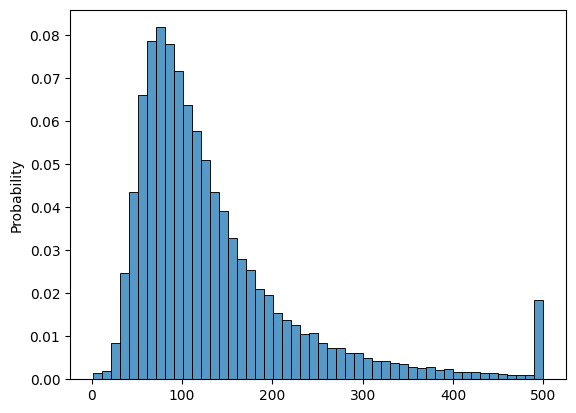

In [121]:
(
    for_modeling.filter(m2_filter).pipe(
        lambda df: sns.histplot(
            df["income"].clip(0, 500), stat="probability", binwidth=10
        )
    )
);

In [122]:
income_rank_expr = (
    pl.col("income")
    .rank("min")
    .mul(5 / pl.count())
    .ceil()
    .cast(int)
    .alias("income_quantile")
)

In [123]:
(
    for_modeling.filter(m2_filter)
    .with_columns(income_rank_expr)
    .group_by("income_quantile")
    .agg(
        pl.col("income").min().alias("min"),
        pl.col("income").max().alias("max"),
        pl.count(),
    )
    .sort("income_quantile")
)

income_quantile,min,max,count
i64,i64,i64,u32
1,1,68,96218
2,69,93,91844
3,94,125,92037
4,126,182,91742
5,183,140000,92274


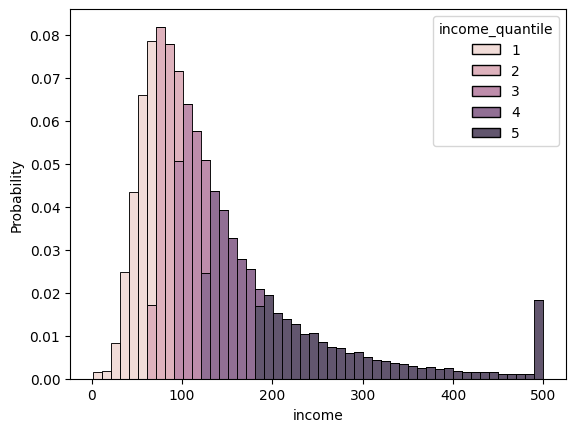

In [124]:
(
    for_modeling.filter(m2_filter)
    .with_columns(income_rank_expr)
    .with_columns(pl.col("income").clip(0, 500))
    .select("income", "income_quantile")
    .pipe(
        lambda df: sns.histplot(
            data=df,
            x="income",
            stat="probability",
            binwidth=10,
            hue="income_quantile",
            multiple="stack",
            common_bins=True,
            common_norm=True,
        )
    )
);

In [125]:
income_results = run_grouped_regressions(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .with_columns(income_rank_expr)
    ),
    indep_vars=get_indep_vars(
        [
            "race_ethn",
            "race_ethn_missing_detailed",
            "ethn_observed",
            "sex",
            "age_without_missing",
            "coapp",
            "income",
            "loan_amount",
            "dti_2",
            "ltv",
            "credit_model",
            "volume",
            "aus_detailed",
            "lender_type",
            "tract_whiteness",
            "tract_income",
            "county_size",
        ]
    ),
    grouping="income_quantile",
    threshold=5000,
)

Cannot use: []


In [126]:
(
    income_results.filter(pl.col("variable").str.starts_with("race_ethn_hl"))
    .with_columns(pl.col("p").ge(0.05 / pl.count()).alias("non_sig"))
    .rename({"subset": "income_quantile"})
    .sort("income_quantile", descending=True)
    .pipe(
        shift_columns_left,
        [
            "variable",
            "non_sig",
            "income_quantile",
            "obs",
            "mean",
            "denial_rate",
            "denial_rate_hl",
        ],
    )
    .pipe(log, "Income quantile results, Model 2")
)

Income quantile results, Model 2:


variable,non_sig,income_quantile,obs,mean,denial_rate,denial_rate_hl,odds_ratio_lower,odds_ratio,odds_ratio_higher,p,prsq,denial_rate_wnhl_loose
str,bool,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""race_ethn_hl""",false,5,70915,0.050469,0.059043,0.075719,1.18,1.36,1.56,0.000024,0.098168,0.048958
"""race_ethn_hl""",false,4,69340,0.073551,0.055725,0.063922,1.11,1.27,1.46,0.000664,0.158595,0.041609
"""race_ethn_hl""",false,3,72332,0.106246,0.062158,0.084841,1.29,1.44,1.6,1.3320e-10,0.177644,0.04468
"""race_ethn_hl""",false,2,70889,0.14273,0.071661,0.08984,1.15,1.27,1.4,0.000004,0.20846,0.051194
"""race_ethn_hl""",false,1,72135,0.167062,0.114965,0.147955,1.25,1.36,1.48,1.6911e-12,0.33095,0.081002


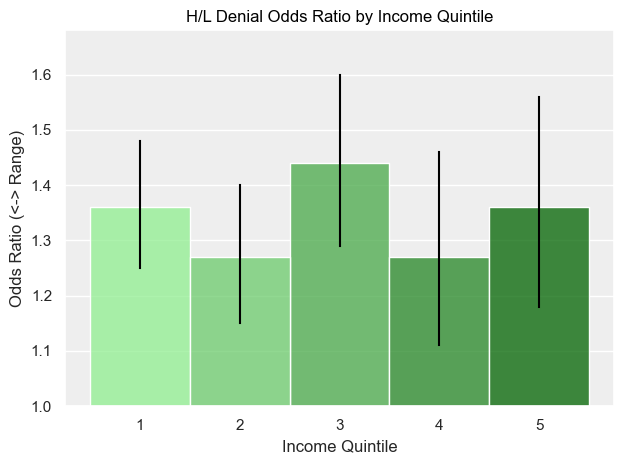

In [127]:
(
    income_results.filter(pl.col("variable").str.starts_with("race_ethn_hl"))
    .with_columns(pl.col("p").ge(0.05 / pl.count()).alias("non_sig"))
    .rename({"subset": "income_quantile"})
    .pipe(
        lambda df: (
            so.Plot(
                data=df.to_pandas(),
                x="income_quantile",
                y="odds_ratio",
                ymin="odds_ratio_lower",
                ymax="odds_ratio_higher",
            )
            .add(so.Range(color="black"))
            .add(so.Bars(alpha=0.75), color="income_quantile", legend=False)
            .scale(color=("lightgreen", "darkgreen"))
            .theme(
                {
                    "axes.facecolor": "#EEE",
                    "axes.edgecolor": "#FFF",
                    "axes.grid.axis": "y",
                }
            )
            .limit(y=(1, None))
            .label(
                title="H/L Denial Odds Ratio by Income Quintile",
                x="Income Quintile",
                y="Odds Ratio (<-> Range)",
            )
            .show()
        )
    )
)
pass

## Simpler comparison

In [128]:
subset_for_simpler_comparison = (
    for_modeling.filter(m2_filter)
    .filter(pl.col("applicant_race_1").eq(5))  # White
    .filter(pl.col("loan_type").eq(1))
    .filter(pl.col("income").ge(40))
    .filter(pl.col("income").lt(200))
    .filter((pl.col("dti_cat_healthy") + pl.col("dti_cat_manageable")) > 0)
    .filter(pl.col("ethn_simple").is_in([1, 2]))
    .with_columns(
        pl.col("ethn_simple")
        .replace(
            {
                1: "Hispanic or Latino",
                2: "Not Hispanic or Latino",
            }
        )
        .alias("Ethnicity")
    )
    .with_columns(
        pl.col("income").mul(1 / 20).cast(int).mul(20).alias("income"),
    )
)

(
    subset_for_simpler_comparison.group_by("income", "Ethnicity")
    .agg(pl.col("is_denied").mean().mul(100).round(2))
    .pivot(
        index="income", columns="Ethnicity", values="is_denied", aggregate_function=None
    )
    .sort("income")
    .select("income", "Not Hispanic or Latino", "Hispanic or Latino")
    .pipe(
        log,
        (
            "Denial rates, white hl vs white non-hl, "
            "healthly/manageable DTI, by income band"
        ),
    )
)

Denial rates, white hl vs white non-hl, healthly/manageable DTI, by income band:


income,Not Hispanic or Latino,Hispanic or Latino
i64,f64,f64
40,4.46,7.05
60,3.59,6.59
80,3.45,5.84
100,3.02,5.13
120,3.2,6.16
140,3.33,4.2
160,3.1,4.89
180,3.0,4.51


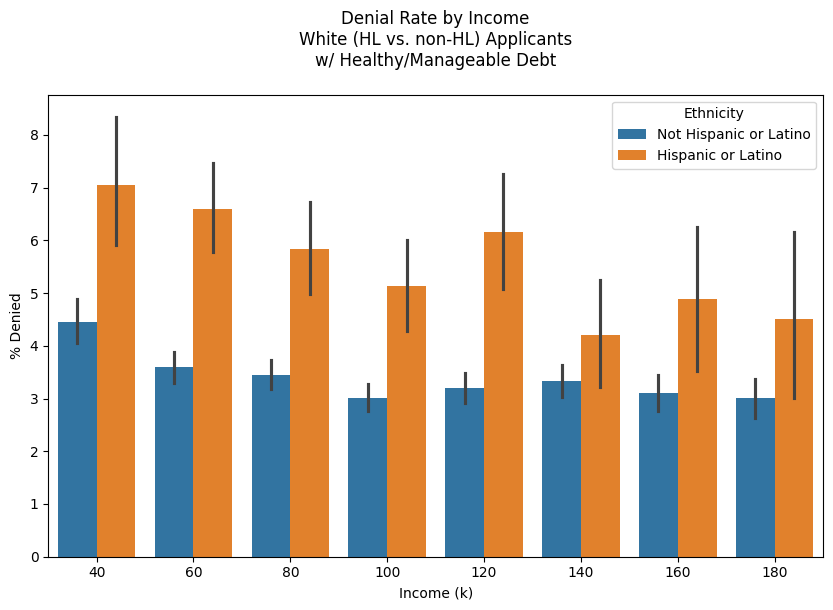

In [129]:
ax = subset_for_simpler_comparison.with_columns(pl.col("is_denied").mul(100)).pipe(
    lambda df: sns.barplot(
        data=df.to_pandas(),
        x="income",
        y="is_denied",
        hue="Ethnicity",
    )
)

ax.figure.set_size_inches((10, 6))
ax.set_ylabel("% Denied")
ax.set_xlabel("Income (k)")
ax.set_title(
    "Denial Rate by Income\n"
    "White (HL vs. non-HL) Applicants\n"
    "w/ Healthy/Manageable Debt\n"
)
pass

## Rate spreads

#### Linear regression to predict the rate spread

In [130]:
model = sm.OLS.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("rate_spread").gt(-5))
        .filter(pl.col("rate_spread").lt(5))
    ),
    formula=m2_formula.replace("is_denied ", "rate_spread "),
)
results = model.fit(disp=0)
# Not using log_regression because this is a linear, not logistic, regression
log(results.summary(), "Rate spread OLS")

Rate spread OLS:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rate_spread   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     2278.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:49:48   Log-Likelihood:            -2.5800e+05
No. Observations:              326390   AIC:                         5.161e+05
Df Residuals:                  326347   BIC:                         5.165e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        3.6756      0.033    110.067      0.000       3.610       3.741
race_ethn_hl                     0.1188      0.003     35.471      0.000       0.112       0.125
race_ethn_black                  0.0755      0.005     16.228      0.000       0.066       0.085
race_ethn_asian                 -0.0278      0.003     -9.270      0.000      -0.034      -0.022
race_ethn_pacific_islander       0.0803      0.032      2.480      0.013       0.017       0.144
race_ethn_native                 0.0450      0.023      1.938      0.053      -0.001       0.090
race_missing                    -0.0332      0.005     -6.112      0.000      -0.044      -0.023
ethn_missing                     0.0079      0.006      1.251      0.211      -0.004       0.020
race_missing:ethn_missing        0.0136      0.009      1.530      0.126      -0.004       0.031
ethn_observed                    0.1175      0.009     13.091      0.000       0.100       0.135
sex_is_female                    0.0115      0.002      5.596      0.000       0.007       0.016
sex_missing_or_both             -0.0064      0.005     -1.250      0.211      -0.016       0.004
age_lt_25                       -0.0134      0.006     -2.170      0.030      -0.025      -0.001
age_25_34                       -0.0452      0.002    -19.256      0.000      -0.050      -0.041
age_45_54                        0.0559      0.003     19.346      0.000       0.050       0.062
age_55_64                        0.0395      0.004     10.979      0.000       0.032       0.047
age_65_plus                      0.0194      0.005      4.103      0.000       0.010       0.029
has_coapplicant                  0.0069      0.002      3.322      0.001       0.003       0.011
income_log10                     0.3852      0.006     63.317      0.000       0.373       0.397
loan_amount_log10               -0.9646      0.007   -147.046      0.000      -0.977      -0.952
dti_cat_manageable               0.1013      0.002     42.728      0.000       0.097       0.106
dti_cat_unmanageable             0.1783      0.003     69.335      0.000       0.173       0.183
dti_cat_struggling               0.2485      0.010     23.715      0.000       0.228       0.269
dti_cat_most_struggling          0.5614      0.019     29.614      0.000       0.524       0.599
combined_loan_to_value_ratio     0.0099   7.63e-05    129.674      0.000       0.010       0.010
credit_model_simple_equifax     -0.0190      0.002     -8.002      0.000      -0.024      -0.014
credit_model_simple_experian    -0.0018      0.003     -0.701      0.483      -0.007       0.003
credit_model_simple_multiple     0.0268      0.004      6.027      0.000       0.018       0.036
credit_model_simple_other        0.0610      0.010      6.037      0.000    

In [131]:
(
    for_modeling.filter(m2_filter)
    .filter(pl.col("loan_type").eq(1))
    .filter(pl.col("rate_spread").gt(-5))
    .filter(pl.col("rate_spread").lt(5))
    .with_columns((pl.col("interest_rate") - pl.col("rate_spread")).alias("apor"))
    .group_by("year")
    .agg(pl.col("apor").median().round(1))
    .sort("year")
)

year,apor
i64,f64
2018,4.4
2019,3.8
2020,3.0
2021,2.8
2022,4.9


Here we examine the effect of adding variables for the (inferred) Average Prime Offer Rate (APOR) and the activity year:

In [132]:
model = sm.OLS.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .filter(pl.col("rate_spread").gt(-5))
        .filter(pl.col("rate_spread").lt(5))
        .with_columns((pl.col("interest_rate") - pl.col("rate_spread")).alias("apor"))
    ),
    formula=m2_formula.replace("is_denied ", "rate_spread ")
    + (
        " + apor"
        " + activity_year_2019"
        " + activity_year_2020"
        " + activity_year_2021"
        " + activity_year_2022"
    ),
)
results = model.fit(disp=0)
# Not using log_regression because this is a linear, not logistic, regression
log(results.summary(), "Rate spread OLS w/ year and inferred APOR")

Rate spread OLS w/ year and inferred APOR:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rate_spread   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     2727.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:49:50   Log-Likelihood:            -2.4496e+05
No. Observations:              325218   AIC:                         4.900e+05
Df Residuals:                  325170   BIC:                         4.905e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.5102      0.033    136.205      0.000       4.445       4.575
race_ethn_hl                     0.1167      0.003     36.054      0.000       0.110       0.123
race_ethn_black                  0.0704      0.004     15.667      0.000       0.062       0.079
race_ethn_asian                 -0.0354      0.003    -12.201      0.000      -0.041      -0.030
race_ethn_pacific_islander       0.0776      0.031      2.484      0.013       0.016       0.139
race_ethn_native                 0.0535      0.022      2.392      0.017       0.010       0.097
race_missing                    -0.0245      0.005     -4.681      0.000      -0.035      -0.014
ethn_missing                     0.0106      0.006      1.728      0.084      -0.001       0.023
race_missing:ethn_missing        0.0055      0.009      0.646      0.518      -0.011       0.022
ethn_observed                    0.0931      0.009     10.684      0.000       0.076       0.110
sex_is_female                    0.0168      0.002      8.468      0.000       0.013       0.021
sex_missing_or_both             -0.0142      0.005     -2.883      0.004      -0.024      -0.005
age_lt_25                       -0.0060      0.006     -1.010      0.312      -0.018       0.006
age_25_34                       -0.0402      0.002    -17.733      0.000      -0.045      -0.036
age_45_54                        0.0520      0.003     18.640      0.000       0.047       0.057
age_55_64                        0.0384      0.003     11.063      0.000       0.032       0.045
age_65_plus                      0.0203      0.005      4.458      0.000       0.011       0.029
has_coapplicant                  0.0061      0.002      3.014      0.003       0.002       0.010
income_log10                     0.3978      0.006     67.042      0.000       0.386       0.409
loan_amount_log10               -0.8971      0.007   -137.574      0.000      -0.910      -0.884
dti_cat_manageable               0.1022      0.002     44.586      0.000       0.098       0.107
dti_cat_unmanageable             0.1834      0.002     73.454      0.000       0.179       0.188
dti_cat_struggling               0.2643      0.010     26.082      0.000       0.244       0.284
dti_cat_most_struggling          0.5825      0.019     30.981      0.000       0.546       0.619
combined_loan_to_value_ratio     0.0085   7.44e-05    113.613      0.000       0.008       0.009
credit_model_simple_equifax     -0.0184      0.002     -8.030      0.000      -0.023      -0.014
credit_model_simple_experian    -0.0007      0.002     -0.285      0.775      -0.006       0.004
credit_model_simple_multiple     0.0239      0.004      5.553      0.000       0.015       0.032
credit_model_simple_other        0.0288      0.010      2.943      0.003    

#### Logistic regression for whether applicant was offered a rate spread > 1

In [133]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .with_columns(pl.col("rate_spread").gt(1).cast(int).alias("high_rate_spread"))
    ),
    formula=m2_formula.replace("is_denied ", "high_rate_spread "),
)
results = model.fit(disp=0)
log_regression(results, "Rate spread Logit (spread >= 1)")

Rate spread Logit (spread >= 1):


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       high_rate_spread   No. Observations:               326557
Model:                          Logit   Df Residuals:                   326514
Method:                           MLE   Df Model:                           42
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.1820
Time:                        21:49:53   Log-Likelihood:                -66028.
converged:                       True   LL-Null:                       -80717.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        9.6561      0.259     37.213      0.000       9.148      10.165
race_ethn_hl                     0.5966      0.022     26.845      0.000       0.553       0.640
race_ethn_black                  0.5982      0.029     20.966      0.000       0.542       0.654
race_ethn_asian                  0.1340      0.027      4.941      0.000       0.081       0.187
race_ethn_pacific_islander       0.2974      0.215      1.383      0.167      -0.124       0.719
race_ethn_native                 0.5348      0.158      3.375      0.001       0.224       0.845
race_missing                    -0.0050      0.039     -0.127      0.899      -0.082       0.072
ethn_missing                     0.0306      0.052      0.587      0.557      -0.071       0.133
race_missing:ethn_missing        0.0363      0.070      0.517      0.605      -0.101       0.174
ethn_observed                    0.4335      0.053      8.169      0.000       0.329       0.537
sex_is_female                    0.0087      0.016      0.539      0.590      -0.023       0.040
sex_missing_or_both             -0.0632      0.043     -1.481      0.139      -0.147       0.020
age_lt_25                       -0.1003      0.042     -2.365      0.018      -0.183      -0.017
age_25_34                       -0.2742      0.019    -14.079      0.000      -0.312      -0.236
age_45_54                        0.2252      0.022     10.296      0.000       0.182       0.268
age_55_64                        0.0958      0.027      3.521      0.000       0.042       0.149
age_65_plus                     -0.1402      0.039     -3.581      0.000      -0.217      -0.063
has_coapplicant                  0.1093      0.017      6.521      0.000       0.076       0.142
income_log10                     2.1171      0.044     48.367      0.000       2.031       2.203
loan_amount_log10               -4.1206      0.049    -84.100      0.000      -4.217      -4.025
dti_cat_manageable               0.5756      0.019     29.594      0.000       0.537       0.614
dti_cat_unmanageable             0.7843      0.020     38.584      0.000       0.744       0.824
dti_cat_struggling               1.0405      0.070     14.777      0.000       0.903       1.179
dti_cat_most_struggling          2.5534      0.086     29.780      0.000       2.385       2.721
combined_loan_to_value_ratio     0.0551      0.001     68.070      0.000       0.054       0.057
credit_model_simple_equifax     -0.0801      0.019     -4.131      0.000      -0.118      -0.042
credit_model_simple_experian     0.0102      0.020      0.505      0.613      -0.029       0.050
credit_model_simple_multiple     0.0844      0.030      2.774      0.006       0.025       0.144
credit_model_simple_other       -0.1530      0.071     -2.153      0.031      -0.292      -0.014
credit_model_simple_missing     -0.0096      0.035     -0.277      0.782      -0.078       0.058
num_decisions_1000              -0.0407 

In [134]:
assess_results(results)

Pseudo R-squared: 0.1820
AUC: 0.814
Recall: 0.066
Precision: 0.549
Accuracy score: 0.933
F-1 score: 0.118
True Approval  : 99.6%
False Approval :  0.4%
False Denial   : 93.4%
True Denial    :  6.6%


Here, as with linear regression above, we test the addition of APOR and activity year variables:

In [135]:
model = sm.Logit.from_formula(
    data=(
        for_modeling.filter(m2_filter)
        .filter(pl.col("loan_type").eq(1))
        .with_columns(pl.col("rate_spread").gt(1).cast(int).alias("high_rate_spread"))
        .with_columns((pl.col("interest_rate") - pl.col("rate_spread")).alias("apor"))
    ),
    formula=m2_formula.replace("is_denied ", "high_rate_spread ")
    + (
        " + apor"
        " + activity_year_2019"
        " + activity_year_2020"
        " + activity_year_2021"
        " + activity_year_2022"
    ),
)
results = model.fit(disp=0)
log_regression(results, "Rate spread Logit (spread >= 1), w/ APOR and year effects")

Rate spread Logit (spread >= 1), w/ APOR and year effects:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       high_rate_spread   No. Observations:               325385
Model:                          Logit   Df Residuals:                   325337
Method:                           MLE   Df Model:                           47
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2196
Time:                        21:49:57   Log-Likelihood:                -62689.
converged:                       True   LL-Null:                       -80325.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       12.4759      0.272     45.878      0.000      11.943      13.009
race_ethn_hl                     0.6170      0.023     27.060      0.000       0.572       0.662
race_ethn_black                  0.6262      0.029     21.355      0.000       0.569       0.684
race_ethn_asian                  0.1063      0.028      3.828      0.000       0.052       0.161
race_ethn_pacific_islander       0.3695      0.220      1.678      0.093      -0.062       0.801
race_ethn_native                 0.5868      0.162      3.625      0.000       0.270       0.904
race_missing                     0.0204      0.040      0.505      0.614      -0.059       0.100
ethn_missing                     0.0583      0.053      1.090      0.276      -0.047       0.163
race_missing:ethn_missing        0.0228      0.072      0.317      0.751      -0.118       0.164
ethn_observed                    0.3630      0.054      6.671      0.000       0.256       0.470
sex_is_female                    0.0192      0.016      1.167      0.243      -0.013       0.052
sex_missing_or_both             -0.1055      0.043     -2.431      0.015      -0.191      -0.020
age_lt_25                       -0.0997      0.044     -2.291      0.022      -0.185      -0.014
age_25_34                       -0.2763      0.020    -13.881      0.000      -0.315      -0.237
age_45_54                        0.2285      0.022     10.213      0.000       0.185       0.272
age_55_64                        0.0901      0.028      3.227      0.001       0.035       0.145
age_65_plus                     -0.1532      0.040     -3.829      0.000      -0.232      -0.075
has_coapplicant                  0.1021      0.017      5.963      0.000       0.069       0.136
income_log10                     2.1001      0.045     46.428      0.000       2.011       2.189
loan_amount_log10               -3.9944      0.052    -77.414      0.000      -4.096      -3.893
dti_cat_manageable               0.5649      0.020     28.407      0.000       0.526       0.604
dti_cat_unmanageable             0.7557      0.021     36.212      0.000       0.715       0.797
dti_cat_struggling               1.0136      0.072     14.030      0.000       0.872       1.155
dti_cat_most_struggling          2.6680      0.090     29.485      0.000       2.491       2.845
combined_loan_to_value_ratio     0.0506      0.001     62.227      0.000       0.049       0.052
credit_model_simple_equifax     -0.0821      0.020     -4.143      0.000      -0.121      -0.043
credit_model_simple_experian     0.0102      0.021      0.496      0.620      -0.030       0.051
credit_model_simple_multiple     0.1064      0.031      3.411      0.001       0.045       0.168
credit_model_simple_other       -0.1587      0.071     -2.225      0.026      -0.298      -0.019
credit_model_simple_missing      0.0026      0.035      0.073      0.941      -0.067       0.072
num_decisions_1000              -0.0410 

In [136]:
assess_results(results)

Pseudo R-squared: 0.2196
AUC: 0.838
Recall: 0.102
Precision: 0.589
Accuracy score: 0.935
F-1 score: 0.173
True Approval  : 99.5%
False Approval :  0.5%
False Denial   : 89.8%
True Denial    : 10.2%


---

---

---